# PREPROCESSING

ATTENTION-LSTM Forecasting with VMD Decomposition on ETTh1 Dataset

In this experiment, we use the ETTh1 dataset (Electricity Transformer Temperature, hourly data) to forecast the oil temperature (OT).
We first apply **Variational Mode Decomposition (VMD)** to extract intrinsic mode components (IMFs) from the `OT` series, 
then use an **Attention-based LSTM (Attn-LSTM)** to capture temporal dependencies and focus on informative time steps.



## Import-Params-Read-Visualization

In [31]:
# Parameters
SEQ_LEN = 24  # past 24 hours for each sample
TARGET_COL = 'OT'  # target variable: Oil Temperature
FEATURE_COLS = ['OT', 'HUFL', 'HULL', 'MUFL', 'MULL', 'LUFL', 'LULL']
EPOCHS = 20 
BATCH_SIZE = 16

# VMD parameters
DC = 0              # no DC part imposed
init = 1            # initialize omegas uniformly
tol = 1e-7
K = 8                  # number of VMD modes (tuneable)
alpha = 1705             # VMD alpha (tuneable)
tau = 0.05805898025979961                # VMD tau

LSTM_UNITS = 128
DROPOUT = 0.5
LEARNING_RATE = 1e-3

In [2]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import os
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import MultiHeadAttention
from tensorflow.keras.layers import Softmax
from vmdpy import VMD
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.layers import RepeatVector
from tensorflow.keras.models import Model,Sequential
from tensorflow.keras.layers import Lambda, Input, LSTM, Dense, Dropout,Bidirectional, Layer,LayerNormalization
from tensorflow.keras.optimizers import Adam
import random
from tensorflow.keras.layers import Reshape
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import mean_squared_error, mean_absolute_error
import tensorflow as tf
from tensorflow.keras.layers import Attention
from tensorflow.keras.layers import Concatenate


2025-12-18 16:05:01.348554: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-12-18 16:05:01.355263: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1766061301.362846    3992 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1766061301.365170    3992 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1766061301.371120    3992 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking 

In [3]:
save_dir = os.path.expanduser("~/Project/Nested_Attention_BiLSTM_VMD/data/raw")
os.makedirs(save_dir, exist_ok=True)
# Full file path
file_path = os.path.join(save_dir, "ETTh1.csv")
# Load it whenever needed
df = pd.read_csv(file_path)
print(df.head())
df.columns = df.columns.str.strip().str.replace('\ufeff', '')
print(df.columns)
# Ensure datetime type
df['date'] = pd.to_datetime(df['date'])
df.set_index('date', inplace=True)
data = df[[TARGET_COL]].values


                  date   HUFL   HULL   MUFL   MULL   LUFL   LULL         OT
0  2016-07-01 00:00:00  5.827  2.009  1.599  0.462  4.203  1.340  30.531000
1  2016-07-01 01:00:00  5.693  2.076  1.492  0.426  4.142  1.371  27.787001
2  2016-07-01 02:00:00  5.157  1.741  1.279  0.355  3.777  1.218  27.787001
3  2016-07-01 03:00:00  5.090  1.942  1.279  0.391  3.807  1.279  25.044001
4  2016-07-01 04:00:00  5.358  1.942  1.492  0.462  3.868  1.279  21.948000
Index(['date', 'HUFL', 'HULL', 'MUFL', 'MULL', 'LUFL', 'LULL', 'OT'], dtype='object')


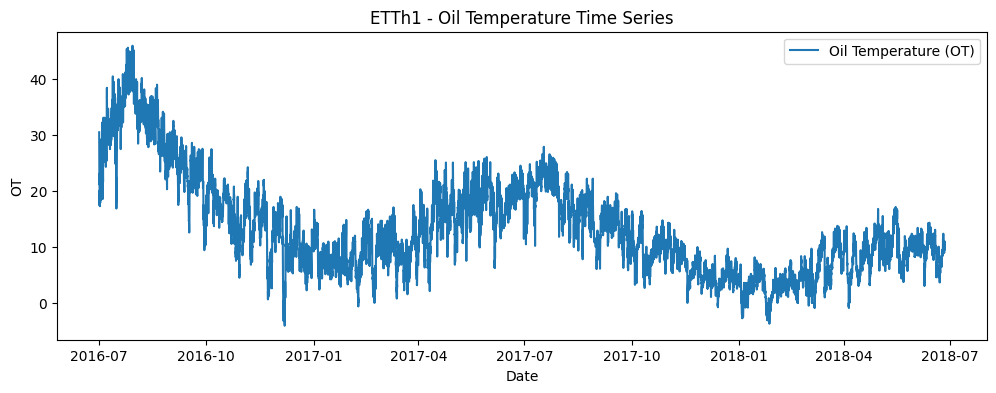

In [4]:
# Visualize
plt.figure(figsize=(12, 4))
plt.plot(df.index, df['OT'], label='Oil Temperature (OT)')
plt.title('ETTh1 - Oil Temperature Time Series')
plt.xlabel('Date')
plt.ylabel('OT')
plt.legend()
plt.show()

## Train_test_split Only Target

In [5]:
# =====================================================
# Split Train/Test
# =====================================================
# ========split_idx = int(len(df) * 0.8)
split_idx = int(len(df) * 0.8)
X_train, X_test = df[FEATURE_COLS].values[:split_idx], df[FEATURE_COLS].values[split_idx:]
y_train, y_test = df[TARGET_COL].values[:split_idx].reshape(-1,1), df[TARGET_COL].values[split_idx:].reshape(-1,1)
train_data = df[:split_idx]
test_data  = df[split_idx:]
# =====================================================
# Helper for VMD-based training data
# =====================================================
def create_sequences_noVMD(X, y, seq_len):
    Xs, ys = [], []
    limit = min(len(X), len(y)) - seq_len
    for i in range(limit):
        Xs.append(X[i:i+seq_len])
        ys.append(y[i+seq_len])
    return np.array(Xs), np.array(ys)
# =====================================================
# Helper: Create sequences for test
# =====================================================
def create_sequences_test(X, y, seq_len, alpha, tau, K):
    """
    Create sequences of length seq_len and apply VMD on each sequence (X only)
    If alpha=0, tau=0, K=1: no VMD applied (simple sequence)
    """
    Xs, ys = [], []
    for i in range(len(X) - seq_len):
        seq_x = X[i:i+seq_len]          # shape: (seq_len, num_features)
        seq_y = y[i+seq_len]            # target aligned after the sequence
        if X.ndim == 1:
            seq_x = seq_x.reshape(seq_len, -1)

        if alpha > 0 and K > 1:
            # Apply VMD on each feature independently
            seq_x_vmd_list = []
            for f in range(seq_x.shape[1]):
                u, _, _ = VMD(seq_x[:, f], alpha, tau, K, DC=0, init=1, tol=1e-7)
                seq_x_vmd_list.append(np.stack(u, axis=1))  # (seq_len, K)
            # Concatenate VMD modes of all features: (seq_len, K*num_features)
            seq_x = np.concatenate(seq_x_vmd_list, axis=1)

        Xs.append(seq_x)
        ys.append(seq_y)

    return np.array(Xs), np.array(ys)

# =====================================================
# Test Sequences
# =====================================================
X_test_vmd_seq,  y_test_vmd_seq  = create_sequences_test(X_test,  y_test,  SEQ_LEN, alpha, tau, K)
# =====================================================
# Scale Train sequences
# =====================================================    
X_train_for_vmd = train_data[TARGET_COL].values.astype(np.float64)
u_train, _, _ = VMD(X_train_for_vmd, alpha, tau, K, DC=0, init=1, tol=1e-7)

vmd_and_novmd_train = np.stack(u_train, axis=1)
scaler_x = MinMaxScaler()
scaler_y = MinMaxScaler()
train_scaled_vmd = scaler_x.fit_transform(vmd_and_novmd_train)
train_scaled_target = scaler_y.fit_transform(train_data[[TARGET_COL]])
X_train_vmd, y_train_vmd = create_sequences_noVMD(train_scaled_vmd, train_scaled_target, SEQ_LEN)
# =====================================================
# Scale Test sequences
# =====================================================  
_, _, feat_dim = X_test_vmd_seq.shape

num_test_seq = X_test_vmd_seq.shape[0]
seq_len = X_test_vmd_seq.shape[1]

# ---- FIX: reshape → scale → reshape ----
# Test 3D VMD sequences
X_test_vmd = scaler_x.transform(
    X_test_vmd_seq.reshape(-1, feat_dim)      # 2D
).reshape(num_test_seq, seq_len, feat_dim)    # back to 3D

# ---- Scale VMD target y ----
y_test_vmd = scaler_y.transform(
    y_test_vmd_seq.reshape(-1, 1)
).flatten()

# If you already have y_test_vmd_scaled, inverse transform:
y_test_vmd_true = scaler_y.inverse_transform(
    y_test_vmd.reshape(-1, 1)
).flatten()

# =====================================================
# simple sequences
# =====================================================
X_train_simple, y_train_simple = create_sequences_noVMD(X_train, y_train, SEQ_LEN)
X_test_simple, y_test_simple   = create_sequences_noVMD(X_test, y_test, SEQ_LEN)
y_test_simple_true = scaler_y.inverse_transform(
    y_test_simple.reshape(-1, 1)
)


/opt/anaconda3/envs/tf-gpu2/lib/python3.11/site-packages/vmdpy/vmdpy.py:114: RuntimeWarning: invalid value encountered in scalar divide
  omega_plus[n+1,k] = np.dot(freqs[T//2:T],(abs(u_hat_plus[n+1, T//2:T, k])**2))/np.sum(abs(u_hat_plus[n+1,T//2:T,k])**2)
/opt/anaconda3/envs/tf-gpu2/lib/python3.11/site-packages/vmdpy/vmdpy.py:112: RuntimeWarning: invalid value encountered in divide
  u_hat_plus[n+1,:,k] = (f_hat_plus - sum_uk - lambda_hat[n,:]/2)/(1+Alpha[k]*(freqs - omega_plus[n,k])**2)


KeyboardInterrupt: 

## Train_test_split Multi Features

In [5]:
# =====================================================
# Split Train/Test
# =====================================================
# ========split_idx = int(len(df) * 0.8)
split_idx = int(len(df) * 0.8)
X_train, X_test = df[FEATURE_COLS].values[:split_idx], df[FEATURE_COLS].values[split_idx:]
y_train, y_test = df[TARGET_COL].values[:split_idx].reshape(-1,1), df[TARGET_COL].values[split_idx:].reshape(-1,1)
train_data = df[:split_idx]
test_data  = df[split_idx:]
# ++++++++++++++++++++++++++++++
VMD_FEATURE_IDXS = [FEATURE_COLS.index('OT')]
# =====================================================
# Helper for VMD-based training data
# =====================================================
def create_sequences_noVMD(X, y, seq_len):
    Xs, ys = [], []
    limit = min(len(X), len(y)) - seq_len
    for i in range(limit):
        Xs.append(X[i:i+seq_len])
        ys.append(y[i+seq_len])
    return np.array(Xs), np.array(ys)
# =====================================================
# Helper: Create sequences for test
# =====================================================
def create_sequences_test(
    X, y, seq_len, alpha, tau, K, vmd_feature_idxs
):
    """
    Apply VMD ONLY on OT feature.
    
    X: (N, num_features)
    y: (N, 1)
    
    Output:
      Xs: (num_seq, seq_len, new_feat_dim)
      ys: (num_seq, 1)
    """
    Xs, ys = [], []
    num_features = X.shape[1]

    for i in range(len(X) - seq_len):
        seq_x = X[i:i+seq_len]        # (seq_len, F)
        seq_y = y[i+seq_len]

        vmd_parts = []
        raw_parts = []

        for f in range(num_features):
            if f in vmd_feature_idxs and alpha > 0 and K > 1:
                # --- VMD only on OT ---
                u, _, _ = VMD(
                    seq_x[:, f].astype(np.float64),
                    alpha, tau, K,
                    DC=0, init=1, tol=1e-7
                )
                vmd_parts.append(np.stack(u, axis=1))  # (seq_len, K)
            else:
                # --- raw feature ---
                raw_parts.append(seq_x[:, f:f+1])      # (seq_len, 1)

        seq_x_out = np.concatenate(vmd_parts + raw_parts, axis=1)

        Xs.append(seq_x_out)
        ys.append(seq_y)

    return np.array(Xs), np.array(ys)
# =====================================================
# Test Sequences
# =====================================================
X_test_vmd_seq,  y_test_vmd_seq  = create_sequences_test(X_test,  y_test,  SEQ_LEN, alpha, tau, K, VMD_FEATURE_IDXS)
# =====================================================
# VMD for TARGET and concat with other features
# =====================================================    
X_train_for_vmd = train_data[TARGET_COL].values.astype(np.float64)
u_train, _, _ = VMD(X_train_for_vmd, alpha, tau, K, DC=0, init=1, tol=1e-7)
vmd_train_cols = np.stack(u_train, axis=1)

# Select non-OT features
other_features = [f for f in FEATURE_COLS if f != TARGET_COL]
raw_train_features = train_data[other_features].values  # shape: (N, F-1)

train_VMD_and_noVMD_features = np.concatenate([vmd_train_cols, raw_train_features], axis=1)  # (N, K + F-1)

# =====================================================
# Scale Train sequences
# =====================================================  
scaler_x = MinMaxScaler()
scaler_y = MinMaxScaler()
train_scaled_vmd = scaler_x.fit_transform(train_VMD_and_noVMD_features)
train_scaled_target = scaler_y.fit_transform(train_data[[TARGET_COL]])
X_train_vmd, y_train_vmd = create_sequences_noVMD(train_scaled_vmd, train_scaled_target, SEQ_LEN)
# =====================================================
# Scale Test sequences
# =====================================================  
_, _, feat_dim = X_test_vmd_seq.shape

num_test_seq = X_test_vmd_seq.shape[0]
seq_len = X_test_vmd_seq.shape[1]

# ---- FIX: reshape → scale → reshape ----
# Test 3D VMD sequences
X_test_vmd = scaler_x.transform(
    X_test_vmd_seq.reshape(-1, feat_dim)      # 2D
).reshape(num_test_seq, seq_len, feat_dim)    # back to 3D

# ---- Scale VMD target y ----
y_test_vmd = scaler_y.transform(
    y_test_vmd_seq.reshape(-1, 1)
).flatten()

# If you already have y_test_vmd_scaled, inverse transform:
y_test_vmd_true = scaler_y.inverse_transform(
    y_test_vmd.reshape(-1, 1)
).flatten()

# =====================================================
# simple sequences
# =====================================================
X_train_simple, y_train_simple = create_sequences_noVMD(X_train, y_train, SEQ_LEN)
X_test_simple, y_test_simple   = create_sequences_noVMD(X_test, y_test, SEQ_LEN)
y_test_simple_true = scaler_y.inverse_transform(
    y_test_simple.reshape(-1, 1)
)


/opt/anaconda3/envs/tf-gpu2/lib/python3.11/site-packages/vmdpy/vmdpy.py:114: RuntimeWarning: invalid value encountered in scalar divide
  omega_plus[n+1,k] = np.dot(freqs[T//2:T],(abs(u_hat_plus[n+1, T//2:T, k])**2))/np.sum(abs(u_hat_plus[n+1,T//2:T,k])**2)
/opt/anaconda3/envs/tf-gpu2/lib/python3.11/site-packages/vmdpy/vmdpy.py:112: RuntimeWarning: invalid value encountered in divide
  u_hat_plus[n+1,:,k] = (f_hat_plus - sum_uk - lambda_hat[n,:]/2)/(1+Alpha[k]*(freqs - omega_plus[n,k])**2)
/opt/anaconda3/envs/tf-gpu2/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


## CUSTOM LAYERS

In [20]:
# ===================================================
# PERFORMER ATTENTION
# ===================================================
class PerformerAttention(Layer):
    def __init__(self, num_heads, model_dim, kernel_eps=1e-6, dropout=0.1, **kwargs):
        super().__init__(**kwargs)
        self.num_heads = num_heads
        self.model_dim = model_dim
        self.kernel_eps = kernel_eps
        self.dropout = Dropout(dropout)
        self.head_dim = model_dim // num_heads
        assert model_dim % num_heads == 0, "model_dim must be divisible by num_heads"

    def build(self, input_shape):
        # Linear projections
        self.Wq = Dense(self.model_dim)
        self.Wk = Dense(self.model_dim)
        self.Wv = Dense(self.model_dim)
        self.Wo = Dense(self.model_dim)
        
        # Random Gaussian projection for FAVOR+
        self.proj = self.add_weight(
            shape=(self.head_dim, self.head_dim),
            initializer="random_normal",
            trainable=False,
            name="proj_matrix"
        )

    def kernel(self, x):
        # FAVOR+ kernel Φ(x)
        x_proj = tf.einsum("...nd,df->...nf", x, self.proj)
        return tf.nn.relu(x_proj) + self.kernel_eps

    def split_heads(self, x):
        B = tf.shape(x)[0]
        T = tf.shape(x)[1]
        x = tf.reshape(x, (B, T, self.num_heads, self.head_dim))
        return tf.transpose(x, [0, 2, 1, 3])  # (B, H, T, Dh)

    def merge_heads(self, x):
        B = tf.shape(x)[0]
        T = tf.shape(x)[2]
        x = tf.transpose(x, [0, 2, 1, 3])
        return tf.reshape(x, (B, T, self.model_dim))

    def call(self, x, training=False):
        Q, K, V = x  # all shape (B, T, model_dim)
        
        # Linear projections + split heads
        Q = self.split_heads(self.Wq(Q))
        K = self.split_heads(self.Wk(K))
        V = self.split_heads(self.Wv(V))
        
        # FAVOR+ kernel
        Q_phi = self.kernel(Q)  # (B, H, T, Dh)
        K_phi = self.kernel(K)
        
        # Compute KV and normalization
        KV = tf.einsum("bhnd,bhne->bhde", K_phi, V)  # (B,H,Dh,Dh)
        Z = 1.0 / (tf.einsum("bhnd,bhd->bhn", Q_phi, tf.reduce_sum(K_phi, axis=2)) + 1e-6)
        out = tf.einsum("bhnd,bhde,bhn->bhne", Q_phi, KV, Z)
        
        # Merge heads
        out = self.merge_heads(out)
        return self.Wo(out)

# ===================================================
# VAE SAMPLING LAYER
# ===================================================
class KLDivergenceLayer(tf.keras.layers.Layer):
    def call(self, inputs):
        mu, log_var = inputs
        kl = -0.5 * tf.reduce_mean(
            1 + log_var - tf.square(mu) - tf.exp(log_var)
        )
        self.add_loss(kl)
        return inputs
class Sampling(tf.keras.layers.Layer):
    def call(self, inputs):
        mu, log_var = inputs
        eps = tf.random.normal(tf.shape(mu))
        return mu + tf.exp(0.5 * log_var) * eps

# =====================================================
# 2️⃣ Bahdanau-style Attention Layer
# =====================================================
class AttentionLayer_Bahdanau(Layer):
    def __init__(self, **kwargs):
        super(AttentionLayer_Bahdanau, self).__init__(**kwargs)

    def build(self, input_shape):
        self.W = self.add_weight(
            shape=(input_shape[-1], input_shape[-1]),
            initializer="glorot_uniform",
            trainable=True,
            name="att_weight"
        )
        self.b = self.add_weight(
            shape=(input_shape[-1],),
            initializer="zeros",
            trainable=True,
            name="att_bias"
        )
        self.u = self.add_weight(
            shape=(input_shape[-1],),
            initializer="glorot_uniform",
            trainable=True,
            name="context_vector"
        )
        super(AttentionLayer_Bahdanau, self).build(input_shape)

    def call(self, x):
        # x shape: (batch, time_steps, features)
        u_it = tf.tanh(tf.tensordot(x, self.W, axes=1) + self.b)   # (batch, time, features)
        a_it = tf.tensordot(u_it, self.u, axes=1)                  # (batch, time)
        a_it = tf.nn.softmax(a_it, axis=1)                         # (batch, time)
        a_it = tf.expand_dims(a_it, axis=-1)                       # (batch, time, 1)
        weighted_output = x * a_it                                  # (batch, time, features)
        return tf.reduce_sum(weighted_output, axis=1)              # (batch, features)

    def compute_output_shape(self, input_shape):
        # output shape: (batch, features)
        return (input_shape[0], input_shape[2])


def build_attlstm_model(input_shape, lstm1_units=128, lstm2_units=64, dense_units=32, dropout=0.2, lr=1e-3):
    inp = Input(shape=input_shape)
    
    # Encoder LSTM
    x = LSTM(lstm1_units, return_sequences=True)(inp)
    x = Dropout(dropout)(x)
    
    # Attention
    att_out = AttentionLayer_Bahdanau()(x)
    
    # Decoder LSTM 
    x = Reshape((1, lstm1_units))(att_out)
    x = LSTM(lstm2_units, return_sequences=False)(x)
    x = Dropout(dropout)(x)
    
    # Dense layers
    x = Dense(dense_units, activation='relu')(x)
    out = Dense(1)(x)
    
    model = Model(inp, out)
    model.compile(optimizer=Adam(lr), loss='mse', metrics=['mae'])
    return model

# ========================================
# 📌     LSTM + Residual Connection + LayerNorm
# ========================================
class LSTM_residual_norm(Layer):
    def __init__(self, units, dropout=0.1, **kwargs):
        super(LSTM_residual_norm, self).__init__(**kwargs)
        self.units = units
        self.dropout_rate = dropout

        self.lstm = LSTM(units, return_sequences=True)
        self.dropout_layer = Dropout(dropout)
        self.norm = LayerNormalization()

    def build(self, input_shape):
        input_dim = input_shape[-1]    # <-- Detect feature count automatically

        # Projection for residual connection
        self.proj = Dense(self.units)  # input_dim → units

        super().build(input_shape)

    def call(self, x):
        h = self.lstm(x)
        h = self.dropout_layer(h)

        h_res = self.proj(x)   # Now works for any feature dimension

        return self.norm(h + h_res)

# ========================================
# 📌  Attention(Bahdanau) + LSTM + Residual Connection + LayerNorm
# ========================================
def build_att_customlstm_model(input_shape, lstm1_units=128, lstm2_units=64, dense_units=32, dropout=0.2, lr=1e-3):
    inp = Input(shape=input_shape)
    
    # Encoder LSTM
    x = LSTM_residual_norm(lstm1_units)(inp)
    x = Dropout(dropout)(x)
    
    # Attention
    att_out = AttentionLayer_Bahdanau()(x)
    
    # Decoder LSTM 
    x = Reshape((1, lstm1_units))(att_out)
    x = LSTM_residual_norm(lstm2_units)(x)
    x = Dropout(dropout)(x)
    
    # Dense layers
    x = Dense(dense_units, activation='relu')(x)
    out = Dense(1)(x)
    
    model = Model(inp, out)
    model.compile(optimizer=Adam(lr), loss='mse', metrics=['mae'])
    return model
    
# =========================================================
# 📌  Custom Luong Attention
# score = h_t · W · h_s  (dot-product)
# =========================================================
class LuongAttention(Layer):
    def __init__(self, units):
        super(LuongAttention, self).__init__()
        self.Wq = Dense(units)
        self.Wv = Dense(units)

    def call(self, query, value, mask=None):
        # Project both → SAME dimension
        q = self.Wq(query)      # (B, T, units)
        v = self.Wv(value)      # (B, T, units)

        # Dot product score
        score = tf.matmul(q, v, transpose_b=True)  # (B, T, T)

        if mask is not None:
            score += (mask * -1e9)

        # Use tf.nn.softmax (Keras-safe)
        attn_weights = tf.nn.softmax(score, axis=-1)     # (B, T, T)
        context = tf.matmul(attn_weights, v)             # (B, T, units)

        return context

# =========================================================
# 📌  Temporal Attention (per timestep)
# =========================================================
class TemporalAttention(Layer):
    def __init__(self, units, **kwargs):
        super().__init__(**kwargs)
        self.units = units

    def build(self, input_shape):
        # input_shape = (batch, timesteps, features)
        d = input_shape[-1]

        self.Wt = Dense(self.units, activation='tanh')
        self.vt = Dense(1)

    def call(self, x):
        # score shape -> (batch, timesteps, units)
        h = self.Wt(x)

        # score shape -> (batch, timesteps, 1)
        score = self.vt(h)

        # attention weights
        alpha = tf.nn.softmax(score, axis=1)

        # weighted sum (batch, timesteps, features) -> (batch, features)
        context = tf.reduce_sum(alpha * x, axis=1)

        return context
        
def build_Tattlstm_model(input_shape, lstm1_units=128, lstm2_units=64, dense_units=32, dropout=0.2, lr=1e-3):

    inp = Input(shape=input_shape)

    # Encoder LSTM
    x = LSTM(lstm1_units, return_sequences=True)(inp)
    x = Dropout(dropout)(x)

    # Temporal Attention
    att_out = TemporalAttention(units=lstm1_units)(x)

    # Decoder LSTM - convert context vector to sequence again
    x = Reshape((1, lstm1_units))(att_out)
    x = LSTM(lstm2_units, return_sequences=False)(x)
    x = Dropout(dropout)(x)

    # Dense layers
    x = Dense(dense_units, activation='relu')(x)
    out = Dense(1)(x)

    model = Model(inp, out)
    model.compile(
        optimizer=Adam(learning_rate=lr),
        loss='mse',
        metrics=['mae']
    )
    return model
# =========================================================
# 📌  Cross-Attention (Query from XLSTM, Key/Value from VMD input)
# =========================================================
class CrossAttention(Layer):
    def __init__(self, num_heads=4, key_dim=32):
        super().__init__()
        self.mha = MultiHeadAttention(num_heads=num_heads, key_dim=key_dim)

    def call(self, query, context, mask=None):
        return self.mha(query=query, value=context, key=context, attention_mask=mask)


# =========================================================
# 📌  Causal Masking (prevent future leakage)
# =========================================================
def causal_mask(seq_len):
    mask = tf.linalg.band_part(tf.ones((seq_len, seq_len)), -1, 0)
    return mask[None, None, :, :]



# =========================================================
# 📌  TFT Multi-Head Temporal self-Attention Layer (Keras)
#     this is a valid implementation of the temporal self-attention block inspired by the TFT paper:
#     Multi-head scaled dot-product attention
#     Decoder state as query
#     Encoder outputs as key/value
#     Layer norm + residual
#     Optional causal masking
#     It is simplified (no gating via GRN or VSN), but the attention math is correct and aligned with Transformer/TFT definitions.
# ========================================================= 
class TFTTemporalAttention(Layer):
    def __init__(self, num_heads, model_dim, dropout_rate=0.1,
                 use_mask=False, **kwargs):
        super().__init__(**kwargs)
        self.num_heads = num_heads
        self.model_dim = model_dim
        self.dropout_rate = dropout_rate
        self.use_mask = use_mask
        
        assert model_dim % num_heads == 0
        self.head_dim = model_dim // num_heads

        self.Wq = Dense(model_dim)
        self.Wk = Dense(model_dim)
        self.Wv = Dense(model_dim)
        self.Wo = Dense(model_dim)

        self.layernorm = LayerNormalization(epsilon=1e-6)
        self.dropout = Dropout(dropout_rate)

    def build(self, input_shape):
        self.Wq.build(input_shape[0])
        self.Wk.build(input_shape[0])
        self.Wv.build(input_shape[0])
        self.Wo.build((None, None, self.model_dim))
        self.layernorm.build((None, None, self.model_dim))
        self.built = True

    def split_heads(self, x, batch_size):
        x = tf.reshape(x, (batch_size, -1,
                           self.num_heads, self.head_dim))
        return tf.transpose(x, perm=[0, 2, 1, 3])

    def call(self, inputs, training=None):
        encoder_out, decoder_state = inputs

        batch_size = tf.shape(encoder_out)[0]

        dec_expanded = tf.repeat(
            tf.expand_dims(decoder_state, axis=1),
            repeats=tf.shape(encoder_out)[1],
            axis=1
        )

        Q = self.Wq(dec_expanded)
        K = self.Wk(encoder_out)
        V = self.Wv(encoder_out)

        Q = self.split_heads(Q, batch_size)
        K = self.split_heads(K, batch_size)
        V = self.split_heads(V, batch_size)

        score = tf.matmul(Q, K, transpose_b=True)
        scale = tf.cast(tf.sqrt(float(self.head_dim)), tf.float32)
        score = score / scale

        if self.use_mask:
            T = tf.shape(encoder_out)[1]
            mask = tf.linalg.band_part(tf.ones((T, T)), -1, 0)
            mask = 1e-9 * (1 - mask)
            score += mask

        alpha = tf.nn.softmax(score, axis=-1)
        att_out = tf.matmul(alpha, V)

        att_out = tf.transpose(att_out, perm=[0, 2, 1, 3])
        att_out = tf.reshape(att_out,
                             (batch_size, -1, self.model_dim))

        out = self.Wo(att_out)

        # residual: input must have same dim
        out = self.layernorm(out)

        return out


def build_TFTattlstm_model(input_shape, lstm1_units=100, lstm2_units=100,
                            dense_units=32, num_heads=8, model_dim=64, dropout=0.1):

    # -------------------------
    # 0. Input
    # -------------------------
    encoder_inputs = Input(shape=input_shape)

    # -------------------------
    # 1. Encoder LSTM
    # -------------------------
    enc_out = LSTM(lstm1_units, return_sequences=True)(encoder_inputs)
    enc_out = Dropout(dropout)(enc_out)
    enc_out = LayerNormalization()(enc_out)
    enc_out = Dense(model_dim)(enc_out)  # project to model_dim
    enc_out = LayerNormalization()(enc_out)

    # -------------------------
    # 1b. Bahdanau Attention applied to encoder
    # -------------------------
    bahdanau_att_1 = AttentionLayer_Bahdanau()(enc_out)
    bahdanau_att_enc = Lambda(lambda x: tf.expand_dims(x, axis=1))(bahdanau_att_1)

    # -------------------------
    # 2. Decoder LSTM
    # -------------------------
    dec_out = LSTM(lstm2_units, return_sequences=True)(bahdanau_att_enc)
    dec_out = Dropout(dropout)(dec_out)
    dec_out = Dense(model_dim)(dec_out)  # ensure same feature dimension
    dec_out = LayerNormalization()(dec_out)

    # Bahdanau attention over decoder
    bahdanau_att_dec = AttentionLayer_Bahdanau()(dec_out)  # shape: (batch, model_dim)
    bahdanau_att_dec = Lambda(lambda x: tf.expand_dims(x, axis=1))(bahdanau_att_dec)  # (B, 1, D)

    # -------------------------
    # 3. TFT Multi-Head Attention Stack
    # -------------------------
    att_layer = TFTTemporalAttention(num_heads=num_heads, model_dim=model_dim)
    att_out = att_layer([bahdanau_att_enc, bahdanau_att_dec])
    # -------------------------
    # 4. Dense output
    # -------------------------
    x = Bidirectional(LSTM(dense_units))(att_out)
    output = Dense(1)(x)

    # -------------------------
    # 5. Model compile
    # -------------------------
    model = Model(encoder_inputs, output)
    model.compile(loss='mse', optimizer='adam', metrics=['mae'])

    return model

def build_TFTattlstm_model2(input_shape, lstm1_units=100, lstm2_units=100,
                            dense_units=32, num_heads=8, model_dim=64, dropout=0.1):

    # -------------------------
    # 0. Input
    # -------------------------
    input_group = Input(shape=input_shape)

    # -------------------------
    # 1. Encoder LSTM
    # -------------------------
    group1 = LSTM(lstm1_units, return_sequences=True)(input_group)
    group1 = Dropout(dropout)(group1)

    # -------------------------
    # 1b. Bahdanau Attention applied to encoder
    # -------------------------
    bahdanau_att_group1 = AttentionLayer_Bahdanau()(group1)
    bahdanau_att_group1 = Lambda(lambda x: tf.expand_dims(x, axis=1))(bahdanau_att_group1)

    # -------------------------
    # 2. Decoder LSTM
    # -------------------------
    group2 = LSTM(lstm1_units, return_sequences=True)(input_group)
    group2 = Dropout(dropout)(group2)

    # Bahdanau attention over decoder
    bahdanau_att_group2 = AttentionLayer_Bahdanau()(group2)
    bahdanau_att_group2 = Lambda(lambda x: tf.expand_dims(x, axis=1))(bahdanau_att_group2)

    # -------------------------
    # 3. TFT Multi-Head Attention Stack
    # -------------------------
    att_layer = TFTTemporalAttention(num_heads=num_heads, model_dim=model_dim)
    att_out = att_layer([bahdanau_att_group1, bahdanau_att_group2])

    # -------------------------
    # 4. Dense output
    # -------------------------
    x = Bidirectional(LSTM(dense_units))(att_out)
    output = Dense(1)(x)

    # -------------------------
    # 5. Model compile
    # -------------------------
    model = Model(input_group, output)
    model.compile(loss='mse', optimizer='adam', metrics=['mae'])

    return model


def build_TFTattlstm_model3(input_shape=(24,8), 
                            lstm1_units=100,
                            dense_units=32, 
                            num_heads=8, 
                            model_dim=64,
                            dropout=0.1):

    # -------------------------
    # 0. Input
    # -------------------------
    input_group = Input(shape=input_shape)   # (24, 8)

    # -------------------------
    # **Split input: group1 = first 4 features, group2 = next 4**
    # -------------------------
    group1_input = Lambda(lambda x: x[:, :, :6])(input_group)   # (24, 4)
    group2_input = Lambda(lambda x: x[:, :, 6:])(input_group)   # (24, 4)
    # -------------------------
    # 1. Encoder LSTM for Group 1
    # -------------------------
    group1 = LSTM(lstm1_units, return_sequences=True)(group1_input)
    group1 = Dropout(dropout)(group1)

    bahdanau_att_group1 = AttentionLayer_Bahdanau()(group1)
    bahdanau_att_group1 = Lambda(lambda x: tf.expand_dims(x, axis=1))(bahdanau_att_group1)
    # -------------------------
    # 2. Encoder LSTM for Group 2
    # -------------------------
    group2 = LSTM(lstm1_units, return_sequences=True)(group2_input)
    group2 = Dropout(dropout)(group2)

    bahdanau_att_group2 = AttentionLayer_Bahdanau()(group2)
    bahdanau_att_group2 = Lambda(lambda x: tf.expand_dims(x, axis=1))(bahdanau_att_group2)
    # -------------------------
    # 3. TFT Multi-Head Temporal Attention
    # -------------------------
    att_layer = TFTTemporalAttention(num_heads=num_heads, model_dim=model_dim)
    att_out = att_layer([bahdanau_att_group1, bahdanau_att_group2])
    # -------------------------
    # 4. Dense Output
    # -------------------------
    output = Dense(1)(att_out)
    # -------------------------
    # 5. Compile Model
    # -------------------------
    model = Model(inputs=input_group, outputs=output)
    model.compile(loss='mse', optimizer='adam', metrics=['mae'])

    return model



# ============================
# BUILD Performer attlstm MODEL WITH cross attention
# ============================

def build_TFTattlstm_model4(
        input_shape=(24,8), 
        lstm1_units=100,
        dense_units=32, 
        num_heads=8, 
        model_dim=64,
        dropout=0.1):

    # -------------------------
    # 0. Input
    # -------------------------
    input_group = Input(shape=input_shape)   # (24, 8)

    # -------------------------
    # Split input
    # -------------------------
    group1_input = Lambda(lambda x: x[:, :, :6])(input_group)   
    group2_input = Lambda(lambda x: x[:, :, 6:])(input_group)   

    # -------------------------
    # 1. Encoder LSTM for Group 1
    # -------------------------
    group1 = LSTM(lstm1_units, return_sequences=True)(group1_input)
    group1 = Dropout(dropout)(group1)
    bahdanau_att_group1 = AttentionLayer_Bahdanau()(group1)
    bahdanau_att_group1 = Lambda(lambda x: tf.expand_dims(x, axis=1))(bahdanau_att_group1)

    # -------------------------
    # 2. Encoder LSTM for Group 2
    # -------------------------
    group2 = LSTM(lstm1_units, return_sequences=True)(group2_input)
    group2 = Dropout(dropout)(group2)
    bahdanau_att_group2 = AttentionLayer_Bahdanau()(group2)
    bahdanau_att_group2 = Lambda(lambda x: tf.expand_dims(x, axis=1))(bahdanau_att_group2)

    # -------------------------
    # 3. Cross Attention
    # -------------------------
    cross = CrossAttention(num_heads=num_heads, key_dim=model_dim)

    g1_to_g2 = cross(query=bahdanau_att_group1, context=bahdanau_att_group2)
    g2_to_g1 = cross(query=bahdanau_att_group2, context=bahdanau_att_group1)
    cross_out = Concatenate(axis=1)([g1_to_g2, g2_to_g1])  # shape: (batch, 2, model_dim)

    # -------------------------
    # 4. Multi-Head Attention (replaces Performer)
    # -------------------------
    mha = MultiHeadAttention(num_heads=num_heads, key_dim=model_dim)
    att_out = mha(query=cross_out, value=cross_out, key=cross_out)
    att_out = Dropout(dropout)(att_out)
    att_out = LayerNormalization(epsilon=1e-6)(att_out)

    # -------------------------
    # 5. LSTM + Output
    # -------------------------
    x = Bidirectional(LSTM(dense_units))(att_out)
    output = Dense(1)(x)

    # -------------------------
    # 6. Model
    # -------------------------
    model = Model(inputs=input_group, outputs=output)
    model.compile(loss='mse', optimizer='adam', metrics=['mae'])

    return model
# ============================
# BUILD TFTattlstm MODEL WITH VAE
# ============================
def build_TFTattlstm_model5(
        input_shape=(24, 8),
        lstm1_units=100,
        dense_units=32,
        latent_dim=16,
        num_heads=8,
        model_dim=64,
        dropout=0.1):

    # -------------------------
    # 0. Input
    # -------------------------
    input_group = Input(shape=input_shape)

    # -------------------------
    # 1. Split Inputs
    # -------------------------
    group1_input = Lambda(lambda x: x[:, :, :6])(input_group)
    group2_input = Lambda(lambda x: x[:, :, 6:])(input_group)

    # -------------------------
    # 2. LSTM + Bahdanau Group1
    # -------------------------
    group1 = LSTM(lstm1_units, return_sequences=True)(group1_input)
    group1 = Dropout(dropout)(group1)
    bahdanau1 = AttentionLayer_Bahdanau()(group1)
    bahdanau1 = Lambda(lambda x: tf.expand_dims(x, 1))(bahdanau1)

    # -------------------------
    # 3. LSTM + Bahdanau Group2
    # -------------------------
    group2 = LSTM(lstm1_units, return_sequences=True)(group2_input)
    group2 = Dropout(dropout)(group2)
    bahdanau2 = AttentionLayer_Bahdanau()(group2)
    bahdanau2 = Lambda(lambda x: tf.expand_dims(x, 1))(bahdanau2)

    # -------------------------
    # 4. CONCAT Bahdanau outputs
    # -------------------------
    combined = Concatenate(axis=1)([bahdanau1, bahdanau2])   # (batch, 2, features)

    # -------------------------
    # 5. Flatten for VAE Encoder
    # -------------------------
    flat = Flatten()(combined)
    flat_dim = flat.shape[-1]     # static

    # -------------------------
    # 6. VAE Encoder
    # -------------------------
    mu = Dense(latent_dim)(flat)
    log_var = Dense(latent_dim)(flat)

    # Apply KL divergence correctly
    mu, log_var = KLDivergenceLayer()([mu, log_var])

    # Sampling
    z = Sampling()([mu, log_var])

    # -------------------------
    # 7. VAE Decoder
    # -------------------------
    decoder_hidden = Dense(64, activation="relu")(z)
    decoder_out = Dense(flat_dim, activation="linear")(decoder_hidden)

    decoder_out_reshaped = Reshape((2, flat_dim // 2))(decoder_out)

    # -------------------------
    # 8. TFT Multi-Head Temporal Attention
    # -------------------------
    att_layer = TFTTemporalAttention(num_heads=num_heads, model_dim=model_dim)
    att_out = att_layer([decoder_out_reshaped, decoder_out_reshaped])

    # -------------------------
    # 9. LSTM + Dense Output
    # -------------------------
    x = Bidirectional(LSTM(dense_units))(att_out)
    output = Dense(1)(x)

    # -------------------------
    # 10. Final Model
    # -------------------------
    model = Model(inputs=input_group, outputs=output)

    model.compile(optimizer="adam", loss="mse", metrics=["mae"])

    return model

# ============================
# BUILD TFTattlstm MODEL WITH PERFORMER
# ============================
def build_TFTattlstm_model6(input_shape=(24,8), 
                            lstm1_units=64,
                            dense_units=8, 
                            num_heads=8, 
                            model_dim=64,
                            dropout=0.1):

    # 0. Input
    input_group = Input(shape=input_shape)   # (seq_len, features)

    # 1. Split input
    group1_input = Lambda(lambda x: x[:, :, :6])(input_group)
    group2_input = Lambda(lambda x: x[:, :, 6:])(input_group)

    # 2. LSTM for group1
    group1 = LSTM(lstm1_units, return_sequences=True)(group1_input)
    group1 = Dropout(dropout)(group1)

    # 3. LSTM for group2
    group2 = LSTM(lstm1_units, return_sequences=True)(group2_input)
    group2 = Dropout(dropout)(group2)

    # 4. Performer Attention on each group
    performer_att_group1 = PerformerAttention(num_heads=num_heads, model_dim=model_dim)(
        [group1, group1, group1]
    )
    performer_att_group2 = PerformerAttention(num_heads=num_heads, model_dim=model_dim)(
        [group2, group2, group2]
    )

    # Take last time step for each group
    performer_att_group1 = Lambda(lambda x: x[:, -1, :], name="group1_last_step")(performer_att_group1)
    performer_att_group2 = Lambda(lambda x: x[:, -1, :], name="group2_last_step")(performer_att_group2)

    # 5. Concatenate
    cross_out = Concatenate()([performer_att_group1, performer_att_group2])

    # 6. Dense + Output
    x = Dense(dense_units, activation='relu')(cross_out)
    output = Dense(1)(x)

    # 7. Compile
    model = Model(inputs=input_group, outputs=output)
    model.compile(loss='mse', optimizer='adam', metrics=['mae'])

    return model

# ============================
# BUILD TFTattlstm MODEL WITH PERFORMER and BAHDANAU
# ============================
def build_TFTattlstm_model7(input_shape=(24,8), 
                            lstm1_units=64,
                            dense_units=8, 
                            num_heads=8, 
                            model_dim=64,
                            dropout=0.1):

    # 0. Input
    input_group = Input(shape=input_shape)   # (seq_len, features)


    # 2. LSTM for group1
    group1 = LSTM(lstm1_units, return_sequences=True)(input_group)
    group1 = Dropout(dropout)(group1)
    group1 = Dense(dense_units)(group1)

    # 3. LSTM for group2
    group2 = LSTM(lstm1_units, return_sequences=True)(input_group)
    group2 = Dropout(dropout)(group2)
    group2 = Dense(dense_units)(group2)
    
    # 4. Bahdanau Attention for group1
    bahdanau_att_group1 = AttentionLayer_Bahdanau()(group1)
    # Expand dims to match Performer output shape
    bahdanau_att_group1 = Lambda(lambda x: tf.expand_dims(x, axis=1), name="group1_bahdanau_expand")(bahdanau_att_group1)
    # Take last step
    bahdanau_att_group1 = Lambda(lambda x: x[:, -1, :], name="group1_last_step")(bahdanau_att_group1)

    # 5. Performer Attention for group2
    performer_att_group2 = PerformerAttention(num_heads=num_heads, model_dim=model_dim)(
        [group2, group2, group2]
    )
    performer_att_group2 = Lambda(lambda x: x[:, -1, :], name="group2_last_step")(performer_att_group2)

    # 6. Concatenate
    cross_out = Concatenate()([bahdanau_att_group1, performer_att_group2])

    # 7. Dense + Output
    x = Dense(dense_units, activation='relu')(cross_out)
    output = Dense(1)(x)

    # 8. Compile
    model = Model(inputs=input_group, outputs=output)
    model.compile(loss='mae', optimizer='adam', metrics=['mse'])

    return model


# AttLSTM+VMD

📚 Reference for Attention Mechanism

**Bahdanau, Dzmitry; Cho, Kyunghyun; Bengio, Yoshua (2014).**
*Neural Machine Translation by Jointly Learning to Align and Translate.*
arXiv:1409.0473

🔗 [https://arxiv.org/abs/1409.0473](https://arxiv.org/abs/1409.0473)


📚 Reference for VMD (Variational Mode Decomposition)

**Dragomiretskiy, K., & Zosso, D. (2014).**
*Variational Mode Decomposition.*
IEEE Transactions on Signal Processing, 62(3), 531–544.

🔗 [https://doi.org/10.1109/TSP.2013.2288675](https://doi.org/10.1109/TSP.2013.2288675)
🔗 [https://arxiv.org/abs/1406.5858](https://arxiv.org/abs/1406.5858)



I0000 00:00:1766061405.227069    3992 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 1126 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3090, pci bus id: 0000:01:00.0, compute capability: 8.6


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 24, 14)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 24, 132)        │        77,616 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 24, 132)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ attention_layer__bahdanau       │ (None, 132)            │        17,688 │
│ (AttentionLayer_Bahdanau)       │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape (Reshape)               │ (None, 1, 132)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 132)            │       139,920 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 132)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │         8,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 243,801 (952.35 KB)

 Trainable params: 243,801 (952.35 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50


I0000 00:00:1766061406.895461   54712 cuda_dnn.cc:529] Loaded cuDNN version 90300


870/870 ━━━━━━━━━━━━━━━━━━━━ 10s 10ms/step - loss: 0.0038 - mae: 0.0401 - val_loss: 0.0017 - val_mae: 0.0348
Epoch 2/50
870/870 ━━━━━━━━━━━━━━━━━━━━ 10s 11ms/step - loss: 7.8704e-04 - mae: 0.0214 - val_loss: 0.0013 - val_mae: 0.0305
Epoch 3/50
870/870 ━━━━━━━━━━━━━━━━━━━━ 10s 12ms/step - loss: 5.4688e-04 - mae: 0.0177 - val_loss: 5.7299e-04 - val_mae: 0.0177
Epoch 4/50
870/870 ━━━━━━━━━━━━━━━━━━━━ 11s 13ms/step - loss: 4.3923e-04 - mae: 0.0159 - val_loss: 6.4057e-04 - val_mae: 0.0186
Epoch 5/50
870/870 ━━━━━━━━━━━━━━━━━━━━ 10s 12ms/step - loss: 3.8869e-04 - mae: 0.0149 - val_loss: 4.8771e-04 - val_mae: 0.0162
Epoch 6/50
870/870 ━━━━━━━━━━━━━━━━━━━━ 10s 12ms/step - loss: 3.3458e-04 - mae: 0.0139 - val_loss: 5.7624e-04 - val_mae: 0.0178
Epoch 7/50
870/870 ━━━━━━━━━━━━━━━━━━━━ 10s 11ms/step - loss: 3.2455e-04 - mae: 0.0136 - val_loss: 5.5320e-04 - val_mae: 0.0186
Epoch 8/50
870/870 ━━━━━━━━━━━━━━━━━━━━ 11s 12ms/step - loss: 2.8868e-04 - mae: 0.0129 - val_loss: 4.1069e-04 - val_mae: 0.0147

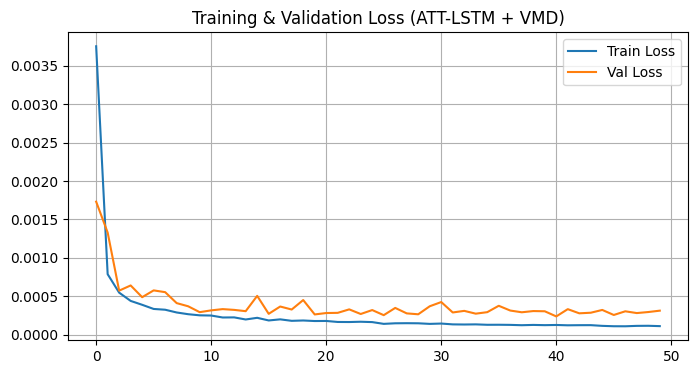

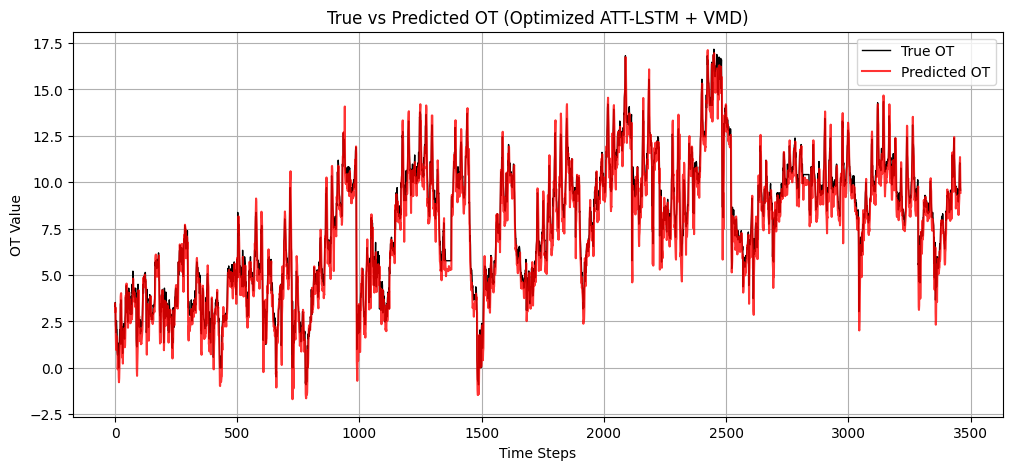

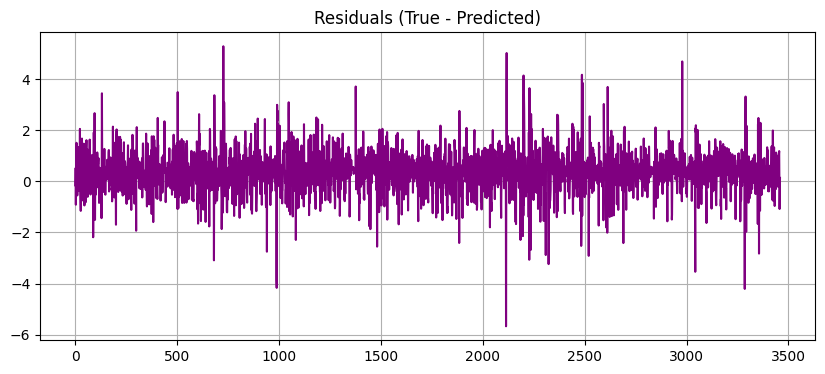

Total Area = 2333.049032131211
Area + = 1818.6328755337756
Area - = -514.4161565974351


In [7]:
model_build_attlstm_model = build_attlstm_model(
    input_shape=(SEQ_LEN, X_train_vmd.shape[2]),
    lstm1_units=132,
    lstm2_units=132,
    dense_units=64
)
model_build_attlstm_model.summary()

history_attlstm_vmd = model_build_attlstm_model.fit(
    X_train_vmd, y_train_vmd,
    validation_data=(X_test_vmd, y_test_vmd),
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    verbose=1
)

# Predict and inverse-transform
y_pred_attlstm_vmd_scaled = model_build_attlstm_model.predict(X_test_vmd)
y_pred_attlstm_vmd_true = scaler_y.inverse_transform(y_pred_attlstm_vmd_scaled)

# =====================================================
# 8️⃣ Visualization
# =====================================================
plt.figure(figsize=(8,4))
plt.plot(history_attlstm_vmd.history['loss'], label='Train Loss')
plt.plot(history_attlstm_vmd.history['val_loss'], label='Val Loss')
plt.title('Training & Validation Loss (ATT-LSTM + VMD)')
plt.legend(); plt.grid(True); plt.show()

plt.figure(figsize=(12,5))
plt.plot(y_test_vmd_true, label='True OT', color='black', linewidth=1)
plt.plot(y_pred_attlstm_vmd_true, label='Predicted OT', color='red', alpha=0.8)
plt.title('True vs Predicted OT (Optimized ATT-LSTM + VMD)')
plt.xlabel('Time Steps'); plt.ylabel('OT Value')
plt.legend(); plt.grid(True); plt.show()

plt.figure(figsize=(10,4))
residuals = y_test_vmd_true - y_pred_attlstm_vmd_true.squeeze()
plt.plot(residuals, color='purple')
plt.title('Residuals (True - Predicted)')
plt.grid(True); plt.show()

res = y_test_vmd_true.squeeze() - y_pred_attlstm_vmd_true.squeeze()
area_total_attlstm_vmd = np.trapezoid(np.abs(res))
print("Total Area =", area_total_attlstm_vmd)
area_positive_attlstm_vmd = np.trapezoid(np.clip(res, 0, None))
area_negative_attlstm_vmd = np.trapezoid(np.clip(res, None, 0))
print("Area + =", area_positive_attlstm_vmd)
print("Area - =", area_negative_attlstm_vmd)

# TAttLSTM+VMD
Temporary Attention + lstm + vmd
📚 Reference for Attention Mechanism

**Bahdanau, Dzmitry; Cho, Kyunghyun; Bengio, Yoshua (2014).**
*Neural Machine Translation by Jointly Learning to Align and Translate.*
arXiv:1409.0473

🔗 [https://arxiv.org/abs/1409.0473](https://arxiv.org/abs/1409.0473)


📚 Reference for VMD (Variational Mode Decomposition)

**Dragomiretskiy, K., & Zosso, D. (2014).**
*Variational Mode Decomposition.*
IEEE Transactions on Signal Processing, 62(3), 531–544.

🔗 [https://doi.org/10.1109/TSP.2013.2288675](https://doi.org/10.1109/TSP.2013.2288675)
🔗 [https://arxiv.org/abs/1406.5858](https://arxiv.org/abs/1406.5858)



Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 24, 14)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 24, 132)        │        77,616 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 24, 132)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ temporal_attention              │ (None, 132)            │        17,689 │
│ (TemporalAttention)             │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape_1 (Reshape)             │ (None, 1, 132)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_3 (LSTM)                   │ (None, 132)            │       139,920 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 132)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 64)             │         8,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 243,802 (952.35 KB)

 Trainable params: 243,802 (952.35 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
870/870 ━━━━━━━━━━━━━━━━━━━━ 10s 11ms/step - loss: 0.0039 - mae: 0.0415 - val_loss: 9.8019e-04 - val_mae: 0.0240
Epoch 2/50
870/870 ━━━━━━━━━━━━━━━━━━━━ 9s 11ms/step - loss: 8.0004e-04 - mae: 0.0214 - val_loss: 7.1350e-04 - val_mae: 0.0203
Epoch 3/50
870/870 ━━━━━━━━━━━━━━━━━━━━ 9s 10ms/step - loss: 5.4680e-04 - mae: 0.0179 - val_loss: 5.2021e-04 - val_mae: 0.0168
Epoch 4/50
870/870 ━━━━━━━━━━━━━━━━━━━━ 9s 11ms/step - loss: 4.0001e-04 - mae: 0.0152 - val_loss: 5.3007e-04 - val_mae: 0.0171
Epoch 5/50
870/870 ━━━━━━━━━━━━━━━━━━━━ 10s 12ms/step - loss: 3.7121e-04 - mae: 0.0146 - val_loss: 3.7600e-04 - val_mae: 0.0142
Epoch 6/50
870/870 ━━━━━━━━━━━━━━━━━━━━ 10s 11ms/step - loss: 2.9932e-04 - mae: 0.0131 - val_loss: 5.6780e-04 - val_mae: 0.0192
Epoch 7/50
870/870 ━━━━━━━━━━━━━━━━━━━━ 9s 11ms/step - loss: 2.9393e-04 - mae: 0.0130 - val_loss: 5.1302e-04 - val_mae: 0.0181
Epoch 8/50
870/870 ━━━━━━━━━━━━━━━━━━━━ 9s 11ms/step - loss: 2.7438e-04 - mae: 0.0126 - val_loss: 4.2105e-04 - v

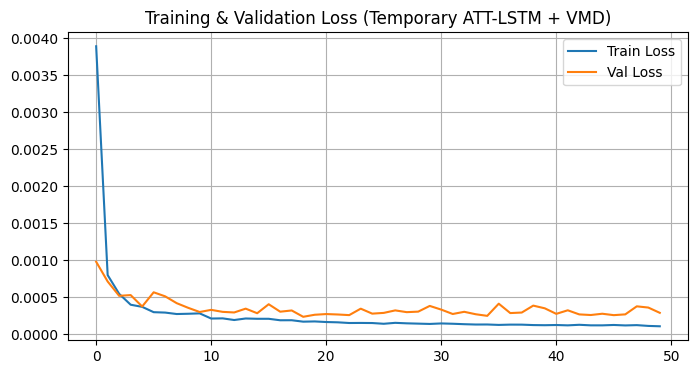

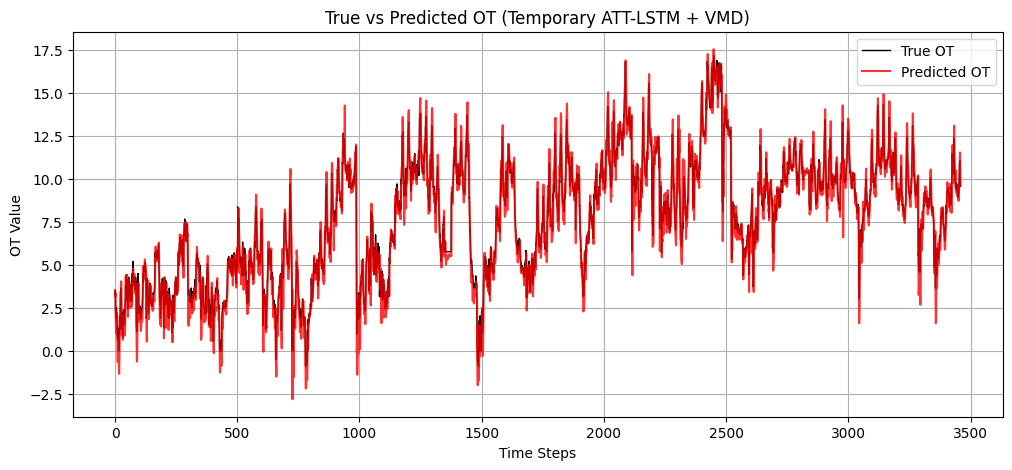

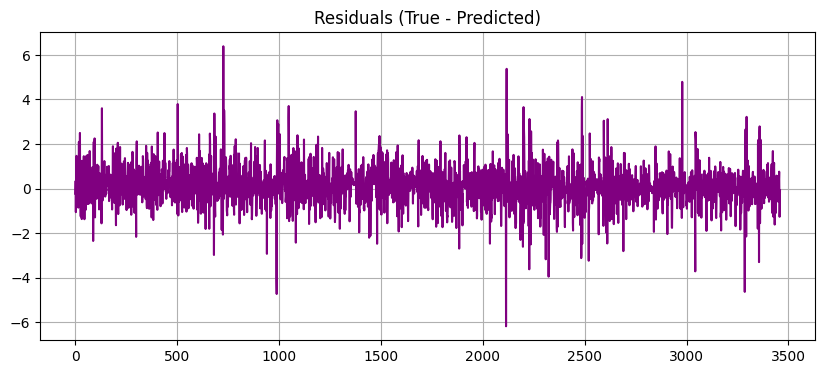

Total Area = 2105.614655762911
Area + = 1302.1644415333876
Area - = -803.4502142295235


In [8]:
model_build_Tattlstm_model = build_Tattlstm_model(
    input_shape=(SEQ_LEN, X_train_vmd.shape[2]),
    lstm1_units=132,
    lstm2_units=132,
    dense_units=64
)
model_build_Tattlstm_model.summary()

history_Tattlstm_vmd = model_build_Tattlstm_model.fit(
    X_train_vmd, y_train_vmd,
    validation_data=(X_test_vmd, y_test_vmd),
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    verbose=1
)

# Predict and inverse-transform
y_pred_Tattlstm_vmd_scaled = model_build_Tattlstm_model.predict(X_test_vmd)
y_pred_Tattlstm_vmd_true = scaler_y.inverse_transform(y_pred_Tattlstm_vmd_scaled)

# =====================================================
# 8️⃣ Visualization
# =====================================================
plt.figure(figsize=(8,4))
plt.plot(history_Tattlstm_vmd.history['loss'], label='Train Loss')
plt.plot(history_Tattlstm_vmd.history['val_loss'], label='Val Loss')
plt.title('Training & Validation Loss (Temporary ATT-LSTM + VMD)')
plt.legend(); plt.grid(True); plt.show()

plt.figure(figsize=(12,5))
plt.plot(y_test_vmd_true, label='True OT', color='black', linewidth=1)
plt.plot(y_pred_Tattlstm_vmd_true, label='Predicted OT', color='red', alpha=0.8)
plt.title('True vs Predicted OT (Temporary ATT-LSTM + VMD)')
plt.xlabel('Time Steps'); plt.ylabel('OT Value')
plt.legend(); plt.grid(True); plt.show()

plt.figure(figsize=(10,4))
residuals = y_test_vmd_true - y_pred_Tattlstm_vmd_true.squeeze()
plt.plot(residuals, color='purple')
plt.title('Residuals (True - Predicted)')
plt.grid(True); plt.show()

res = y_test_vmd_true.squeeze() - y_pred_Tattlstm_vmd_true.squeeze()
area_total_Tattlstm_vmd = np.trapezoid(np.abs(res))
print("Total Area =", area_total_Tattlstm_vmd)
area_positive_Tattlstm_vmd = np.trapezoid(np.clip(res, 0, None))
area_negative_Tattlstm_vmd = np.trapezoid(np.clip(res, None, 0))
print("Area + =", area_positive_Tattlstm_vmd)
print("Area - =", area_negative_Tattlstm_vmd)

# TFT Multi-Head Temporal self-Attention lstm

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 24, 14)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_4 (LSTM)       │ (None, 24, 128)   │     73,216 │ input_layer_2[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_4 (Dropout) │ (None, 24, 128)   │          0 │ lstm_4[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalization │ (None, 24, 128)   │        256 │ dropout_4[0][0]   │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_6 (Dense)     │ (None, 24, 64)    │      8,256 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 24, 64)    │        128 │ dense_6[0][0]     │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ attention_layer__b… │ (None, 64)        │      4,224 │ layer_normalizat… │
│ (AttentionLayer_Ba… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda (Lambda)     │ (None, 1, 64)     │          0 │ attention_layer_… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_5 (LSTM)       │ (None, 1, 128)    │     98,816 │ lambda[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_5 (Dropout) │ (None, 1, 128)    │          0 │ lstm_5[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_7 (Dense)     │ (None, 1, 64)     │      8,256 │ dropout_5[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 1, 64)     │        128 │ dense_7[0][0]     │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ attention_layer__b… │ (None, 64)        │      4,224 │ layer_normalizat… │
│ (AttentionLayer_Ba… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda_1 (Lambda)   │ (None, 1, 64)     │          0 │ attention_layer_… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ tft_temporal_atten… │ (None, None, 64)  │     16,768 │ lambda[0][0],     │
│ (TFTTemporalAttent… │                   │            │ lambda_1[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional       │ (None, 32)        │     10,368 │ tft_temporal_att… │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_12 (Dense)    │ (None, 1)         │         33 │ bidirectional[0]… │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 224,673 (877.63 KB)

 Trainable params: 224,673 (877.63 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
870/870 ━━━━━━━━━━━━━━━━━━━━ 19s 19ms/step - loss: 0.0038 - mae: 0.0374 - val_loss: 9.7590e-04 - val_mae: 0.0249
Epoch 2/50
870/870 ━━━━━━━━━━━━━━━━━━━━ 15s 17ms/step - loss: 7.0476e-04 - mae: 0.0205 - val_loss: 9.2327e-04 - val_mae: 0.0240
Epoch 3/50
870/870 ━━━━━━━━━━━━━━━━━━━━ 17s 19ms/step - loss: 5.0760e-04 - mae: 0.0174 - val_loss: 5.6659e-04 - val_mae: 0.0179
Epoch 4/50
870/870 ━━━━━━━━━━━━━━━━━━━━ 16s 18ms/step - loss: 4.0860e-04 - mae: 0.0155 - val_loss: 8.9751e-04 - val_mae: 0.0241
Epoch 5/50
870/870 ━━━━━━━━━━━━━━━━━━━━ 16s 18ms/step - loss: 3.4806e-04 - mae: 0.0144 - val_loss: 5.7704e-04 - val_mae: 0.0182
Epoch 6/50
870/870 ━━━━━━━━━━━━━━━━━━━━ 18s 20ms/step - loss: 2.8789e-04 - mae: 0.0129 - val_loss: 3.9062e-04 - val_mae: 0.0146
Epoch 7/50
870/870 ━━━━━━━━━━━━━━━━━━━━ 16s 18ms/step - loss: 2.7048e-04 - mae: 0.0128 - val_loss: 3.1209e-04 - val_mae: 0.0127
Epoch 8/50
870/870 ━━━━━━━━━━━━━━━━━━━━ 17s 20ms/step - loss: 2.6088e-04 - mae: 0.0125 - val_loss: 4.5180e-0

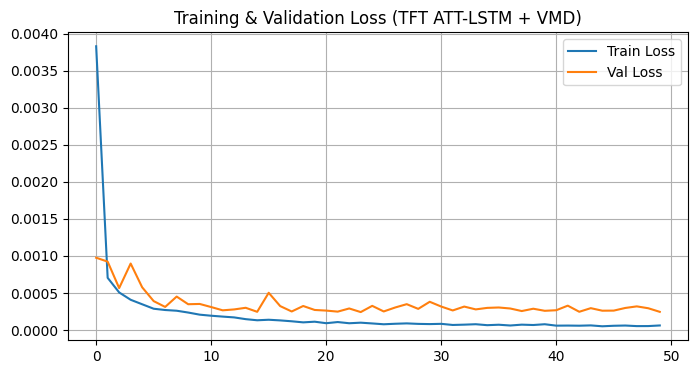

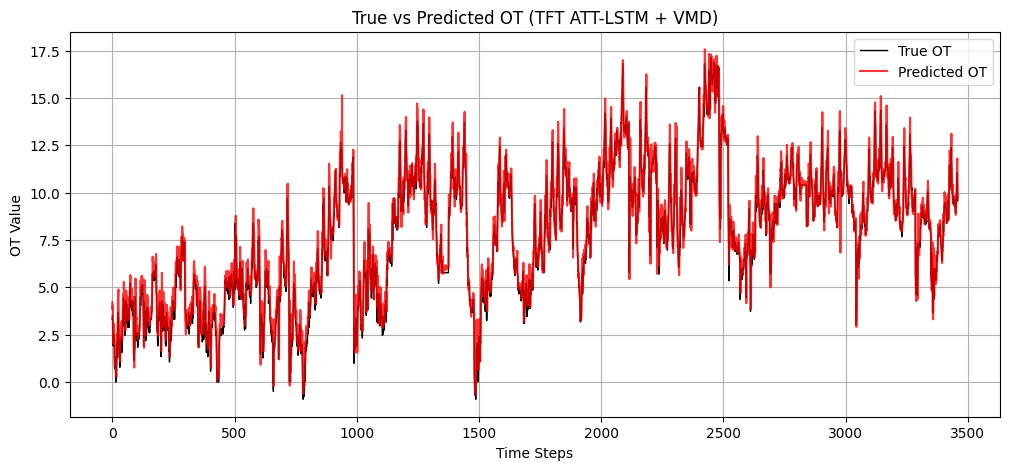

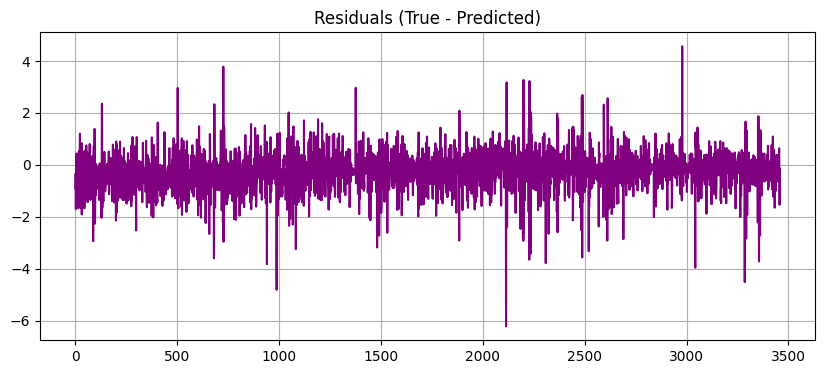

Total Area = 1952.1829901263118
Area + = 518.8067669123418
Area - = -1433.3762232139698


In [9]:
model_build_TFTattlstm_model = build_TFTattlstm_model(
    input_shape=(SEQ_LEN, X_train_vmd.shape[2]),
    lstm1_units=128,
    lstm2_units=128,
    dense_units=16,
    num_heads=8,
    model_dim=64,
    dropout=0.1
)

model_build_TFTattlstm_model.summary()

history_TFTattlstm_vmd = model_build_TFTattlstm_model.fit(
    X_train_vmd, y_train_vmd,
    validation_data=(X_test_vmd, y_test_vmd),
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    verbose=1
)

# Predict and inverse-transform
y_pred_TFTattlstm_vmd_scaled = model_build_TFTattlstm_model.predict(X_test_vmd)
# Flatten to 2D: (num_samples*time_steps, 1)
y_pred_flat = y_pred_TFTattlstm_vmd_scaled.reshape(-1, 1)
# Inverse transform
y_pred_TFTattlstm_vmd_true = scaler_y.inverse_transform(y_pred_flat)

# Optional: reshape back to (num_samples, time_steps)
y_pred_TFTattlstm_vmd_true = y_pred_TFTattlstm_vmd_true.reshape(y_pred_TFTattlstm_vmd_scaled.shape[0],
                                                                y_pred_TFTattlstm_vmd_scaled.shape[1])
# =====================================================
# 8️⃣ Visualization
# =====================================================
plt.figure(figsize=(8,4))
plt.plot(history_TFTattlstm_vmd.history['loss'], label='Train Loss')
plt.plot(history_TFTattlstm_vmd.history['val_loss'], label='Val Loss')
plt.title('Training & Validation Loss (TFT ATT-LSTM + VMD)')
plt.legend(); plt.grid(True); plt.show()

plt.figure(figsize=(12,5))
plt.plot(y_test_vmd_true, label='True OT', color='black', linewidth=1)
plt.plot(y_pred_TFTattlstm_vmd_true, label='Predicted OT', color='red', alpha=0.8)
plt.title('True vs Predicted OT (TFT ATT-LSTM + VMD)')
plt.xlabel('Time Steps'); plt.ylabel('OT Value')
plt.legend(); plt.grid(True); plt.show()

plt.figure(figsize=(10,4))
residuals = y_test_vmd_true.squeeze() - y_pred_TFTattlstm_vmd_true.squeeze()
plt.plot(residuals, color='purple')
plt.title('Residuals (True - Predicted)')
plt.grid(True); plt.show()


res = y_test_vmd_true.squeeze() - y_pred_TFTattlstm_vmd_true.squeeze()
area_total_TFTattlstm_vmd = np.trapezoid(np.abs(res))
print("Total Area =", area_total_TFTattlstm_vmd)
area_positive_TFTattlstm_vmd = np.trapezoid(np.clip(res, 0, None))
area_negative_TFTattlstm_vmd = np.trapezoid(np.clip(res, None, 0))
print("Area + =", area_positive_TFTattlstm_vmd)
print("Area - =", area_negative_TFTattlstm_vmd)

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3       │ (None, 24, 14)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_7 (LSTM)       │ (None, 24, 128)   │     73,216 │ input_layer_3[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_8 (LSTM)       │ (None, 24, 128)   │     73,216 │ input_layer_3[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_7 (Dropout) │ (None, 24, 128)   │          0 │ lstm_7[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_8 (Dropout) │ (None, 24, 128)   │          0 │ lstm_8[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ attention_layer__b… │ (None, 128)       │     16,640 │ dropout_7[0][0]   │
│ (AttentionLayer_Ba… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ attention_layer__b… │ (None, 128)       │     16,640 │ dropout_8[0][0]   │
│ (AttentionLayer_Ba… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda_2 (Lambda)   │ (None, 1, 128)    │          0 │ attention_layer_… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda_3 (Lambda)   │ (None, 1, 128)    │          0 │ attention_layer_… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ tft_temporal_atten… │ (None, None, 64)  │     29,056 │ lambda_2[0][0],   │
│ (TFTTemporalAttent… │                   │            │ lambda_3[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_1     │ (None, 32)        │     10,368 │ tft_temporal_att… │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_17 (Dense)    │ (None, 1)         │         33 │ bidirectional_1[… │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 219,169 (856.13 KB)

 Trainable params: 219,169 (856.13 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
870/870 ━━━━━━━━━━━━━━━━━━━━ 18s 18ms/step - loss: 0.0032 - mae: 0.0351 - val_loss: 8.6760e-04 - val_mae: 0.0227
Epoch 2/50
870/870 ━━━━━━━━━━━━━━━━━━━━ 16s 18ms/step - loss: 6.8345e-04 - mae: 0.0204 - val_loss: 0.0013 - val_mae: 0.0298
Epoch 3/50
870/870 ━━━━━━━━━━━━━━━━━━━━ 16s 18ms/step - loss: 5.6118e-04 - mae: 0.0182 - val_loss: 7.0444e-04 - val_mae: 0.0204
Epoch 4/50
870/870 ━━━━━━━━━━━━━━━━━━━━ 16s 19ms/step - loss: 3.9987e-04 - mae: 0.0155 - val_loss: 7.5419e-04 - val_mae: 0.0218
Epoch 5/50
870/870 ━━━━━━━━━━━━━━━━━━━━ 16s 19ms/step - loss: 3.4737e-04 - mae: 0.0144 - val_loss: 8.2127e-04 - val_mae: 0.0242
Epoch 6/50
870/870 ━━━━━━━━━━━━━━━━━━━━ 16s 19ms/step - loss: 2.9657e-04 - mae: 0.0133 - val_loss: 3.8813e-04 - val_mae: 0.0146
Epoch 7/50
870/870 ━━━━━━━━━━━━━━━━━━━━ 16s 19ms/step - loss: 2.5685e-04 - mae: 0.0124 - val_loss: 4.2489e-04 - val_mae: 0.0155
Epoch 8/50
870/870 ━━━━━━━━━━━━━━━━━━━━ 15s 17ms/step - loss: 2.3831e-04 - mae: 0.0118 - val_loss: 6.1865e-04 - 

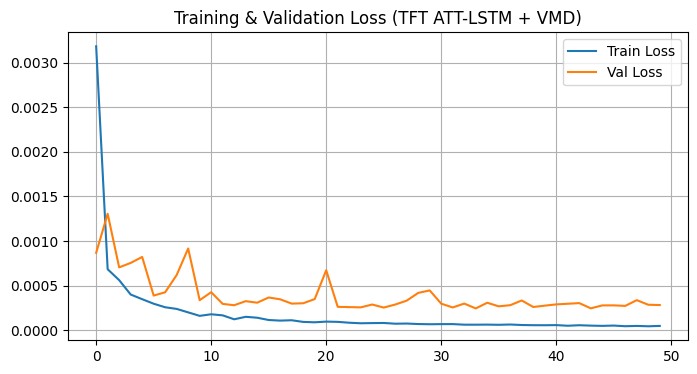

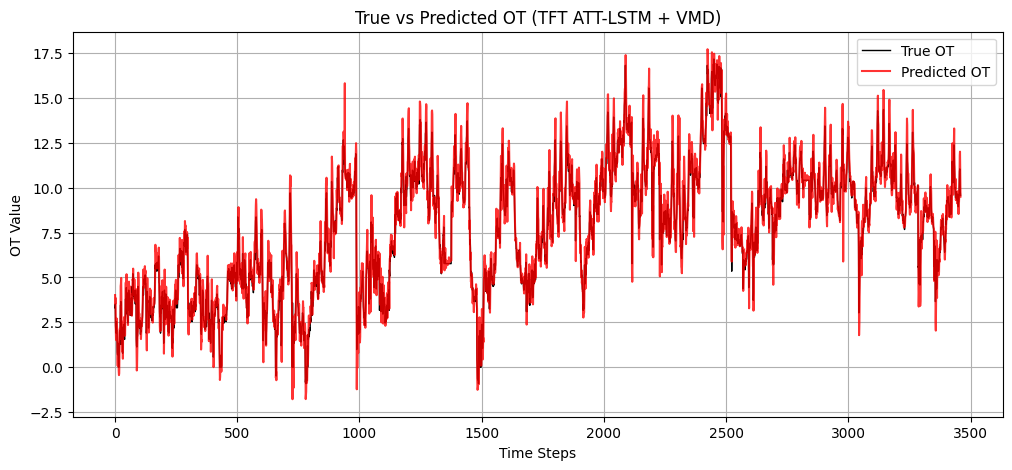

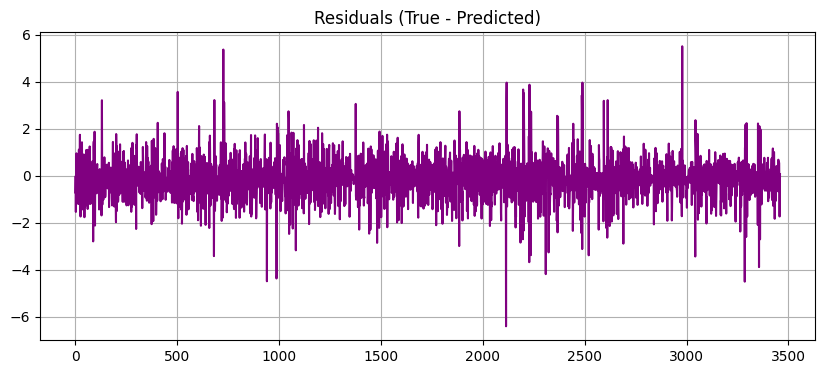

Total Area = 2076.230329188751
Area + = 804.8090660527821
Area - = -1271.4212631359687


In [10]:
model_build_TFTattlstm_model = build_TFTattlstm_model2(
    input_shape=(SEQ_LEN, X_train_vmd.shape[2]),
    lstm1_units=128,
    lstm2_units=128,
    dense_units=16,
    num_heads=8,
    model_dim=64,
    dropout=0.1
)

model_build_TFTattlstm_model.summary()

history_TFTattlstm_vmd = model_build_TFTattlstm_model.fit(
    X_train_vmd, y_train_vmd,
    validation_data=(X_test_vmd, y_test_vmd),
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    verbose=1
)

# Predict and inverse-transform
y_pred_TFTattlstm_vmd_scaled = model_build_TFTattlstm_model.predict(X_test_vmd)
# Flatten to 2D: (num_samples*time_steps, 1)
y_pred_flat = y_pred_TFTattlstm_vmd_scaled.reshape(-1, 1)
# Inverse transform
y_pred_TFTattlstm_vmd_true = scaler_y.inverse_transform(y_pred_flat)

# Optional: reshape back to (num_samples, time_steps)
y_pred_TFTattlstm_vmd_true = y_pred_TFTattlstm_vmd_true.reshape(y_pred_TFTattlstm_vmd_scaled.shape[0],
                                                                y_pred_TFTattlstm_vmd_scaled.shape[1])
# =====================================================
# 8️⃣ Visualization
# =====================================================
plt.figure(figsize=(8,4))
plt.plot(history_TFTattlstm_vmd.history['loss'], label='Train Loss')
plt.plot(history_TFTattlstm_vmd.history['val_loss'], label='Val Loss')
plt.title('Training & Validation Loss (TFT ATT-LSTM + VMD)')
plt.legend(); plt.grid(True); plt.show()

plt.figure(figsize=(12,5))
plt.plot(y_test_vmd_true, label='True OT', color='black', linewidth=1)
plt.plot(y_pred_TFTattlstm_vmd_true, label='Predicted OT', color='red', alpha=0.8)
plt.title('True vs Predicted OT (TFT ATT-LSTM + VMD)')
plt.xlabel('Time Steps'); plt.ylabel('OT Value')
plt.legend(); plt.grid(True); plt.show()

plt.figure(figsize=(10,4))
residuals = y_test_vmd_true.squeeze() - y_pred_TFTattlstm_vmd_true.squeeze()
plt.plot(residuals, color='purple')
plt.title('Residuals (True - Predicted)')
plt.grid(True); plt.show()


res = y_test_vmd_true.squeeze() - y_pred_TFTattlstm_vmd_true.squeeze()
area_total_TFTattlstm_vmd = np.trapezoid(np.abs(res))
print("Total Area =", area_total_TFTattlstm_vmd)
area_positive_TFTattlstm_vmd = np.trapezoid(np.clip(res, 0, None))
area_negative_TFTattlstm_vmd = np.trapezoid(np.clip(res, None, 0))
print("Area + =", area_positive_TFTattlstm_vmd)
print("Area - =", area_negative_TFTattlstm_vmd)

Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_4       │ (None, 24, 14)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda_4 (Lambda)   │ (None, 24, 6)     │          0 │ input_layer_4[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda_5 (Lambda)   │ (None, 24, 8)     │          0 │ input_layer_4[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_10 (LSTM)      │ (None, 24, 64)    │     18,176 │ lambda_4[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_11 (LSTM)      │ (None, 24, 64)    │     18,688 │ lambda_5[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_10          │ (None, 24, 64)    │          0 │ lstm_10[0][0]     │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_11          │ (None, 24, 64)    │          0 │ lstm_11[0][0]     │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ attention_layer__b… │ (None, 64)        │      4,224 │ dropout_10[0][0]  │
│ (AttentionLayer_Ba… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ attention_layer__b… │ (None, 64)        │      4,224 │ dropout_11[0][0]  │
│ (AttentionLayer_Ba… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda_6 (Lambda)   │ (None, 1, 64)     │          0 │ attention_layer_… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda_7 (Lambda)   │ (None, 1, 64)     │          0 │ attention_layer_… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ tft_temporal_atten… │ (None, None, 256) │    116,224 │ lambda_6[0][0],   │
│ (TFTTemporalAttent… │                   │            │ lambda_7[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_22 (Dense)    │ (None, None, 1)   │        257 │ tft_temporal_att… │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 161,793 (632.00 KB)

 Trainable params: 161,793 (632.00 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
870/870 ━━━━━━━━━━━━━━━━━━━━ 15s 15ms/step - loss: 0.1012 - mae: 0.0869 - val_loss: 0.0013 - val_mae: 0.0275
Epoch 2/50
870/870 ━━━━━━━━━━━━━━━━━━━━ 13s 15ms/step - loss: 0.0019 - mae: 0.0336 - val_loss: 0.0011 - val_mae: 0.0248
Epoch 3/50
870/870 ━━━━━━━━━━━━━━━━━━━━ 13s 15ms/step - loss: 0.0016 - mae: 0.0313 - val_loss: 0.0037 - val_mae: 0.0548
Epoch 4/50
870/870 ━━━━━━━━━━━━━━━━━━━━ 14s 17ms/step - loss: 0.0014 - mae: 0.0294 - val_loss: 0.0025 - val_mae: 0.0421
Epoch 5/50
870/870 ━━━━━━━━━━━━━━━━━━━━ 13s 15ms/step - loss: 0.0015 - mae: 0.0307 - val_loss: 0.0012 - val_mae: 0.0266
Epoch 6/50
870/870 ━━━━━━━━━━━━━━━━━━━━ 13s 15ms/step - loss: 0.0014 - mae: 0.0292 - val_loss: 0.0033 - val_mae: 0.0498
Epoch 7/50
870/870 ━━━━━━━━━━━━━━━━━━━━ 13s 15ms/step - loss: 0.0011 - mae: 0.0256 - val_loss: 0.0019 - val_mae: 0.0354
Epoch 8/50
870/870 ━━━━━━━━━━━━━━━━━━━━ 13s 15ms/step - loss: 9.3855e-04 - mae: 0.0240 - val_loss: 0.0011 - val_mae: 0.0248
Epoch 9/50
870/870 ━━━━━━━━━━━━━━━━━

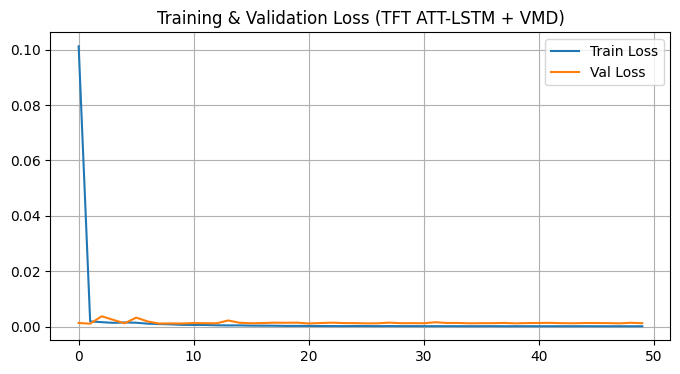

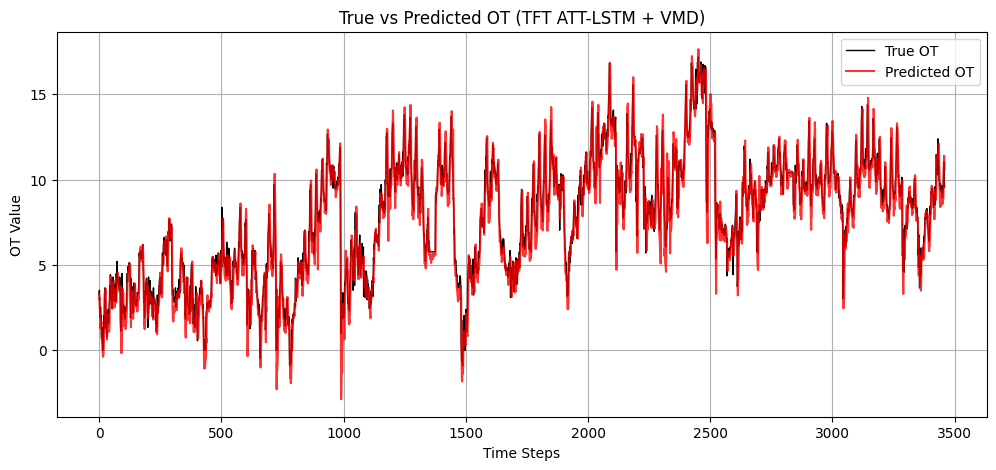

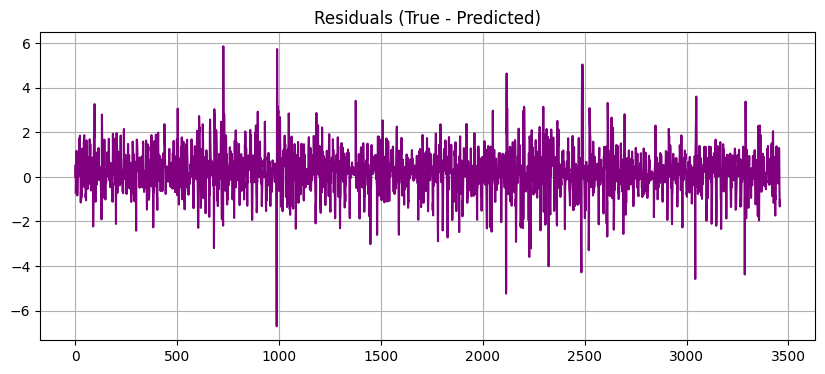

Total Area = 2475.168570316397
Area + = 1653.70116353687
Area - = -821.4674067795272


In [11]:
model_build_TFTattlstm_model = build_TFTattlstm_model3(
    input_shape=(SEQ_LEN, X_train_vmd.shape[2]),
    lstm1_units=64,
    dense_units=4,
    num_heads=64,
    model_dim=256,
    dropout=0.1
)

model_build_TFTattlstm_model.summary()

history_TFTattlstm_vmd = model_build_TFTattlstm_model.fit(
    X_train_vmd, y_train_vmd,
    validation_data=(X_test_vmd, y_test_vmd),
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    verbose=1
)

# Predict and inverse-transform
y_pred_TFTattlstm_vmd_scaled = model_build_TFTattlstm_model.predict(X_test_vmd)
# Flatten to 2D: (num_samples*time_steps, 1)
y_pred_flat = y_pred_TFTattlstm_vmd_scaled.reshape(-1, 1)
# Inverse transform
y_pred_TFTattlstm_vmd_true = scaler_y.inverse_transform(y_pred_flat)

# Optional: reshape back to (num_samples, time_steps)
y_pred_TFTattlstm_vmd_true = y_pred_TFTattlstm_vmd_true.reshape(y_pred_TFTattlstm_vmd_scaled.shape[0],
                                                                y_pred_TFTattlstm_vmd_scaled.shape[1])
# =====================================================
# 8️⃣ Visualization
# =====================================================
plt.figure(figsize=(8,4))
plt.plot(history_TFTattlstm_vmd.history['loss'], label='Train Loss')
plt.plot(history_TFTattlstm_vmd.history['val_loss'], label='Val Loss')
plt.title('Training & Validation Loss (TFT ATT-LSTM + VMD)')
plt.legend(); plt.grid(True); plt.show()

plt.figure(figsize=(12,5))
plt.plot(y_test_vmd_true, label='True OT', color='black', linewidth=1)
plt.plot(y_pred_TFTattlstm_vmd_true, label='Predicted OT', color='red', alpha=0.8)
plt.title('True vs Predicted OT (TFT ATT-LSTM + VMD)')
plt.xlabel('Time Steps'); plt.ylabel('OT Value')
plt.legend(); plt.grid(True); plt.show()

plt.figure(figsize=(10,4))
residuals = y_test_vmd_true.squeeze() - y_pred_TFTattlstm_vmd_true.squeeze()
plt.plot(residuals, color='purple')
plt.title('Residuals (True - Predicted)')
plt.grid(True); plt.show()


res = y_test_vmd_true.squeeze() - y_pred_TFTattlstm_vmd_true.squeeze()
area_total_TFTattlstm_vmd = np.trapezoid(np.abs(res))
print("Total Area =", area_total_TFTattlstm_vmd)
area_positive_TFTattlstm_vmd = np.trapezoid(np.clip(res, 0, None))
area_negative_TFTattlstm_vmd = np.trapezoid(np.clip(res, None, 0))
print("Area + =", area_positive_TFTattlstm_vmd)
print("Area - =", area_negative_TFTattlstm_vmd)

Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_5       │ (None, 24, 14)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda_9 (Lambda)   │ (None, 24, 8)     │          0 │ input_layer_5[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda_8 (Lambda)   │ (None, 24, 6)     │          0 │ input_layer_5[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_13 (LSTM)      │ (None, 24, 32)    │      5,248 │ lambda_9[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_12 (LSTM)      │ (None, 24, 32)    │      4,992 │ lambda_8[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_14          │ (None, 24, 32)    │          0 │ lstm_13[0][0]     │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_13          │ (None, 24, 32)    │          0 │ lstm_12[0][0]     │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ attention_layer__b… │ (None, 32)        │      1,088 │ dropout_14[0][0]  │
│ (AttentionLayer_Ba… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ attention_layer__b… │ (None, 32)        │      1,088 │ dropout_13[0][0]  │
│ (AttentionLayer_Ba… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda_11 (Lambda)  │ (None, 1, 32)     │          0 │ attention_layer_… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda_10 (Lambda)  │ (None, 1, 32)     │          0 │ attention_layer_… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ cross_attention     │ (None, 1, 32)     │     67,104 │ lambda_11[0][0],  │
│ (CrossAttention)    │                   │            │ lambda_10[0][0],  │
│                     │                   │            │ lambda_10[0][0],  │
│                     │                   │            │ lambda_11[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 2, 32)     │          0 │ cross_attention[… │
│ (Concatenate)       │                   │            │ cross_attention[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 2, 32)     │     67,104 │ concatenate[0][0… │
│ (MultiHeadAttentio… │                   │            │ concatenate[0][0… │
│                     │                   │            │ concatenate[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_17          │ (None, 2, 32)     │          0 │ multi_head_atten… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 2, 32)     │         64 │ dropout_17[0][0]  │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_2     │ (None, 8)         │      1,184 │ layer_normalizat… │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_23 (Dense)    │ (None, 1)         │          9 │ bidirectional_2[

 Total params: 147,881 (577.66 KB)

 Trainable params: 147,881 (577.66 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
870/870 ━━━━━━━━━━━━━━━━━━━━ 19s 19ms/step - loss: 0.0058 - mae: 0.0491 - val_loss: 8.6670e-04 - val_mae: 0.0226
Epoch 2/50
870/870 ━━━━━━━━━━━━━━━━━━━━ 18s 20ms/step - loss: 0.0011 - mae: 0.0249 - val_loss: 0.0011 - val_mae: 0.0268
Epoch 3/50
870/870 ━━━━━━━━━━━━━━━━━━━━ 18s 20ms/step - loss: 8.4236e-04 - mae: 0.0223 - val_loss: 0.0011 - val_mae: 0.0260
Epoch 4/50
870/870 ━━━━━━━━━━━━━━━━━━━━ 18s 21ms/step - loss: 7.0568e-04 - mae: 0.0204 - val_loss: 8.3177e-04 - val_mae: 0.0224
Epoch 5/50
870/870 ━━━━━━━━━━━━━━━━━━━━ 17s 20ms/step - loss: 5.9140e-04 - mae: 0.0185 - val_loss: 0.0018 - val_mae: 0.0350
Epoch 6/50
870/870 ━━━━━━━━━━━━━━━━━━━━ 18s 20ms/step - loss: 5.5024e-04 - mae: 0.0180 - val_loss: 6.9612e-04 - val_mae: 0.0198
Epoch 7/50
870/870 ━━━━━━━━━━━━━━━━━━━━ 17s 19ms/step - loss: 5.0359e-04 - mae: 0.0172 - val_loss: 0.0010 - val_mae: 0.0254
Epoch 8/50
870/870 ━━━━━━━━━━━━━━━━━━━━ 16s 19ms/step - loss: 4.4675e-04 - mae: 0.0162 - val_loss: 5.3867e-04 - val_mae: 0.0171


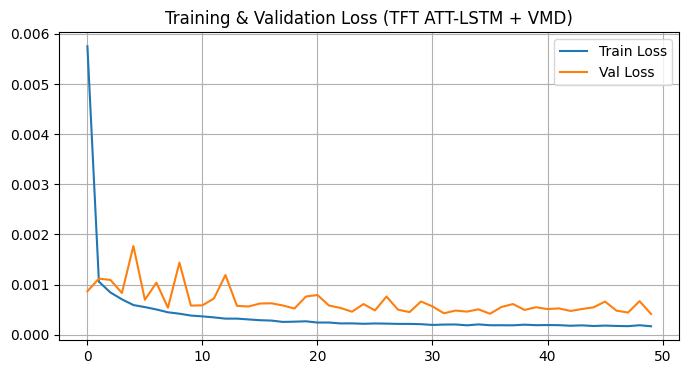

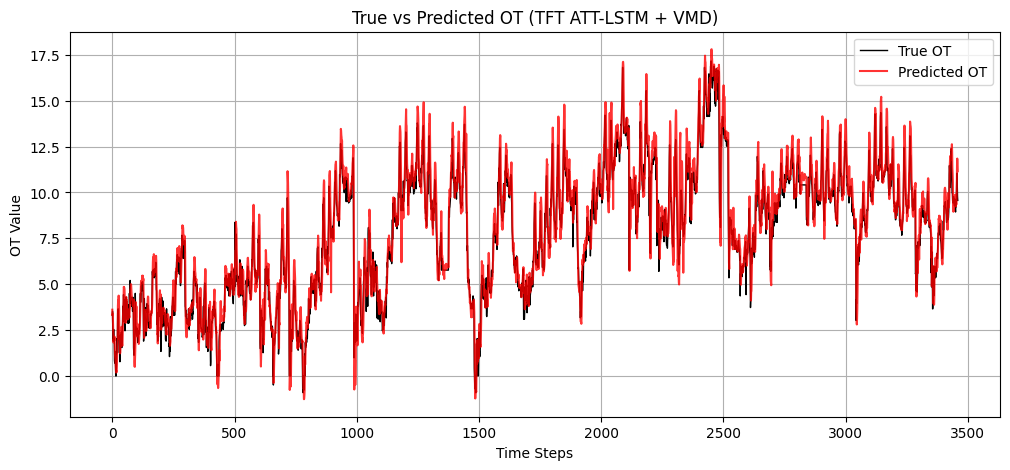

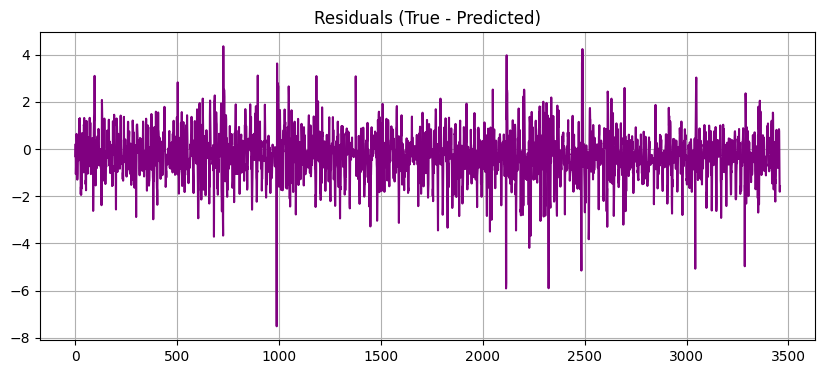

Total Area = 2560.3185847345735
Area + = 806.0166175607596
Area - = -1754.3019671738139


In [12]:
model_build_TFTattlstm_model = build_TFTattlstm_model4(
    input_shape=(SEQ_LEN, X_train_vmd.shape[2]),
    lstm1_units=32,
    dense_units=4,
    num_heads=8,
    model_dim=64,
    dropout=0.1
)

model_build_TFTattlstm_model.summary()

history_TFTattlstm_vmd = model_build_TFTattlstm_model.fit(
    X_train_vmd, y_train_vmd,
    validation_data=(X_test_vmd, y_test_vmd),
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    verbose=1
)

# Predict and inverse-transform
y_pred_TFTattlstm_vmd_scaled = model_build_TFTattlstm_model.predict(X_test_vmd)
# Flatten to 2D: (num_samples*time_steps, 1)
y_pred_flat = y_pred_TFTattlstm_vmd_scaled.reshape(-1, 1)
# Inverse transform
y_pred_TFTattlstm_vmd_true = scaler_y.inverse_transform(y_pred_flat)

# Optional: reshape back to (num_samples, time_steps)
y_pred_TFTattlstm_vmd_true = y_pred_TFTattlstm_vmd_true.reshape(y_pred_TFTattlstm_vmd_scaled.shape[0],
                                                                y_pred_TFTattlstm_vmd_scaled.shape[1])
# =====================================================
# 8️⃣ Visualization
# =====================================================
plt.figure(figsize=(8,4))
plt.plot(history_TFTattlstm_vmd.history['loss'], label='Train Loss')
plt.plot(history_TFTattlstm_vmd.history['val_loss'], label='Val Loss')
plt.title('Training & Validation Loss (TFT ATT-LSTM + VMD)')
plt.legend(); plt.grid(True); plt.show()

plt.figure(figsize=(12,5))
plt.plot(y_test_vmd_true, label='True OT', color='black', linewidth=1)
plt.plot(y_pred_TFTattlstm_vmd_true, label='Predicted OT', color='red', alpha=0.8)
plt.title('True vs Predicted OT (TFT ATT-LSTM + VMD)')
plt.xlabel('Time Steps'); plt.ylabel('OT Value')
plt.legend(); plt.grid(True); plt.show()

plt.figure(figsize=(10,4))
residuals = y_test_vmd_true.squeeze() - y_pred_TFTattlstm_vmd_true.squeeze()
plt.plot(residuals, color='purple')
plt.title('Residuals (True - Predicted)')
plt.grid(True); plt.show()


res = y_test_vmd_true.squeeze() - y_pred_TFTattlstm_vmd_true.squeeze()
area_total_TFTattlstm_vmd = np.trapezoid(np.abs(res))
print("Total Area =", area_total_TFTattlstm_vmd)
area_positive_TFTattlstm_vmd = np.trapezoid(np.clip(res, 0, None))
area_negative_TFTattlstm_vmd = np.trapezoid(np.clip(res, None, 0))
print("Area + =", area_positive_TFTattlstm_vmd)
print("Area - =", area_negative_TFTattlstm_vmd)

Model: "functional_6"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_6       │ (None, 24, 14)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda_12 (Lambda)  │ (None, 24, 6)     │          0 │ input_layer_6[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda_13 (Lambda)  │ (None, 24, 8)     │          0 │ input_layer_6[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_15 (LSTM)      │ (None, 24, 64)    │     18,176 │ lambda_12[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_16 (LSTM)      │ (None, 24, 64)    │     18,688 │ lambda_13[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_18          │ (None, 24, 64)    │          0 │ lstm_15[0][0]     │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_19          │ (None, 24, 64)    │          0 │ lstm_16[0][0]     │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ attention_layer__b… │ (None, 64)        │      4,224 │ dropout_18[0][0]  │
│ (AttentionLayer_Ba… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ attention_layer__b… │ (None, 64)        │      4,224 │ dropout_19[0][0]  │
│ (AttentionLayer_Ba… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda_14 (Lambda)  │ (None, 1, 64)     │          0 │ attention_layer_… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda_15 (Lambda)  │ (None, 1, 64)     │          0 │ attention_layer_… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_1       │ (None, 2, 64)     │          0 │ lambda_14[0][0],  │
│ (Concatenate)       │                   │            │ lambda_15[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten (Flatten)   │ (None, 128)       │          0 │ concatenate_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_24 (Dense)    │ (None, 16)        │      2,064 │ flatten[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_25 (Dense)    │ (None, 16)        │      2,064 │ flatten[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ kl_divergence_layer │ [(None, 16),      │          0 │ dense_24[0][0],   │
│ (KLDivergenceLayer) │ (None, 16)]       │            │ dense_25[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sampling (Sampling) │ (None, 16)        │          0 │ kl_divergence_la… │
│                     │                   │            │ kl_divergence_la… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_26 (Dense)    │ (None, 64)        │      1,088 │ sampling[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_27 (Dense)    │ (None, 128)       │      8,320 │ dense_26[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape_2 (Reshape) │ (None, 2, 64)     │          0 │ dense_27[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ tft_temporal_atten… │ (None, None, 256) │    116,224 │ reshape_2[0][0],

 Total params: 192,049 (750.19 KB)

 Trainable params: 192,049 (750.19 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
870/870 ━━━━━━━━━━━━━━━━━━━━ 19s 20ms/step - loss: 0.0337 - mae: 0.1439 - val_loss: 0.0238 - val_mae: 0.1389
Epoch 2/50
870/870 ━━━━━━━━━━━━━━━━━━━━ 17s 20ms/step - loss: 0.0316 - mae: 0.1409 - val_loss: 0.0242 - val_mae: 0.1404
Epoch 3/50
870/870 ━━━━━━━━━━━━━━━━━━━━ 17s 19ms/step - loss: 0.0316 - mae: 0.1409 - val_loss: 0.0246 - val_mae: 0.1416
Epoch 4/50
870/870 ━━━━━━━━━━━━━━━━━━━━ 17s 20ms/step - loss: 0.0316 - mae: 0.1410 - val_loss: 0.0239 - val_mae: 0.1393
Epoch 5/50
870/870 ━━━━━━━━━━━━━━━━━━━━ 17s 20ms/step - loss: 0.0316 - mae: 0.1410 - val_loss: 0.0234 - val_mae: 0.1375
Epoch 6/50
870/870 ━━━━━━━━━━━━━━━━━━━━ 19s 22ms/step - loss: 0.0315 - mae: 0.1409 - val_loss: 0.0244 - val_mae: 0.1411
Epoch 7/50
870/870 ━━━━━━━━━━━━━━━━━━━━ 17s 20ms/step - loss: 0.0316 - mae: 0.1409 - val_loss: 0.0257 - val_mae: 0.1454
Epoch 8/50
870/870 ━━━━━━━━━━━━━━━━━━━━ 18s 20ms/step - loss: 0.0316 - mae: 0.1409 - val_loss: 0.0265 - val_mae: 0.1483
Epoch 9/50
870/870 ━━━━━━━━━━━━━━━━━━━━ 

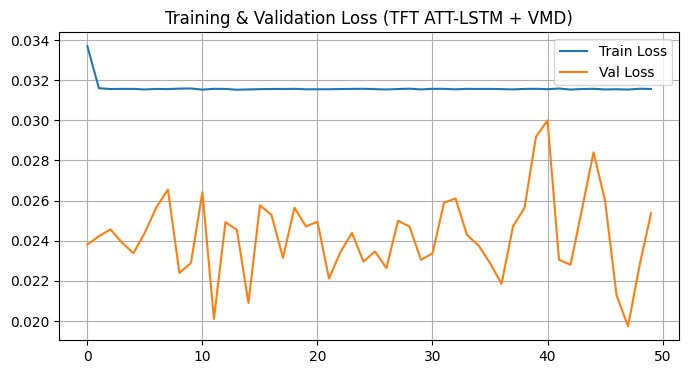

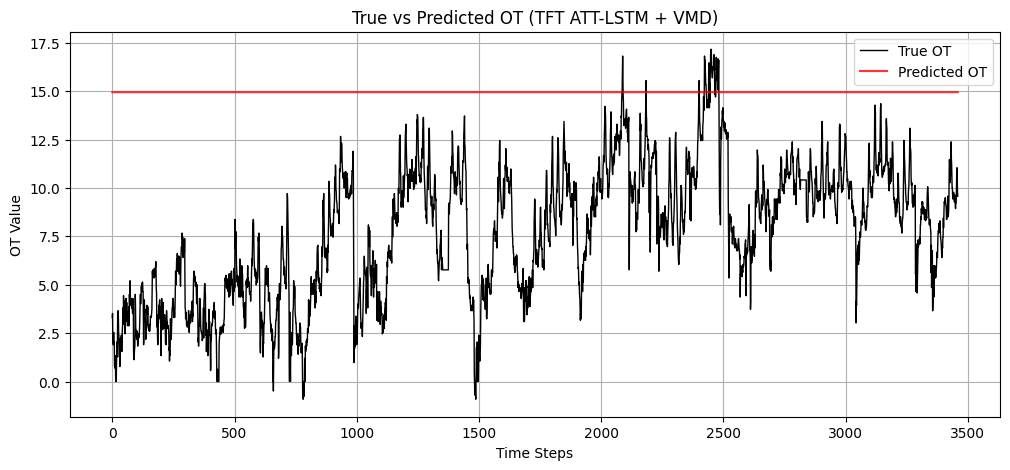

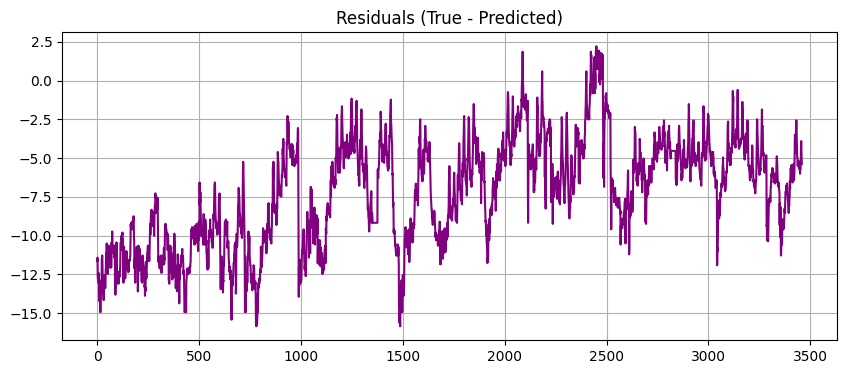

Total Area = 25005.026611179113
Area + = 56.128034591674805
Area - = -24948.89857658744


In [13]:
model_build_TFTattlstm_model = build_TFTattlstm_model5(
    input_shape=(SEQ_LEN, X_train_vmd.shape[2]),
    lstm1_units=64,
    dense_units=8,
    num_heads=8,
    model_dim=256,
    dropout=0.1
)

model_build_TFTattlstm_model.summary()

history_TFTattlstm_vmd = model_build_TFTattlstm_model.fit(
    X_train_vmd, y_train_vmd,
    validation_data=(X_test_vmd, y_test_vmd),
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    verbose=1
)

# Predict and inverse-transform
y_pred_TFTattlstm_vmd_scaled = model_build_TFTattlstm_model.predict(X_test_vmd)
# Flatten to 2D: (num_samples*time_steps, 1)
y_pred_flat = y_pred_TFTattlstm_vmd_scaled.reshape(-1, 1)
# Inverse transform
y_pred_TFTattlstm_vmd_true = scaler_y.inverse_transform(y_pred_flat)

# Optional: reshape back to (num_samples, time_steps)
y_pred_TFTattlstm_vmd_true = y_pred_TFTattlstm_vmd_true.reshape(y_pred_TFTattlstm_vmd_scaled.shape[0],
                                                                y_pred_TFTattlstm_vmd_scaled.shape[1])
# =====================================================
# 8️⃣ Visualization
# =====================================================
plt.figure(figsize=(8,4))
plt.plot(history_TFTattlstm_vmd.history['loss'], label='Train Loss')
plt.plot(history_TFTattlstm_vmd.history['val_loss'], label='Val Loss')
plt.title('Training & Validation Loss (TFT ATT-LSTM + VMD)')
plt.legend(); plt.grid(True); plt.show()

plt.figure(figsize=(12,5))
plt.plot(y_test_vmd_true, label='True OT', color='black', linewidth=1)
plt.plot(y_pred_TFTattlstm_vmd_true, label='Predicted OT', color='red', alpha=0.8)
plt.title('True vs Predicted OT (TFT ATT-LSTM + VMD)')
plt.xlabel('Time Steps'); plt.ylabel('OT Value')
plt.legend(); plt.grid(True); plt.show()

plt.figure(figsize=(10,4))
residuals = y_test_vmd_true.squeeze() - y_pred_TFTattlstm_vmd_true.squeeze()
plt.plot(residuals, color='purple')
plt.title('Residuals (True - Predicted)')
plt.grid(True); plt.show()


res = y_test_vmd_true.squeeze() - y_pred_TFTattlstm_vmd_true.squeeze()
area_total_TFTattlstm_vmd = np.trapezoid(np.abs(res))
print("Total Area =", area_total_TFTattlstm_vmd)
area_positive_TFTattlstm_vmd = np.trapezoid(np.clip(res, 0, None))
area_negative_TFTattlstm_vmd = np.trapezoid(np.clip(res, None, 0))
print("Area + =", area_positive_TFTattlstm_vmd)
print("Area - =", area_negative_TFTattlstm_vmd)

Model: "functional_7"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_7       │ (None, 24, 14)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda_16 (Lambda)  │ (None, 24, 6)     │          0 │ input_layer_7[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda_17 (Lambda)  │ (None, 24, 8)     │          0 │ input_layer_7[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_18 (LSTM)      │ (None, 24, 64)    │     18,176 │ lambda_16[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_19 (LSTM)      │ (None, 24, 64)    │     18,688 │ lambda_17[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_21          │ (None, 24, 64)    │          0 │ lstm_18[0][0]     │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_22          │ (None, 24, 64)    │          0 │ lstm_19[0][0]     │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ performer_attention │ (None, 24, 256)   │    115,776 │ dropout_21[0][0], │
│ (PerformerAttentio… │                   │            │ dropout_21[0][0], │
│                     │                   │            │ dropout_21[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ performer_attentio… │ (None, 24, 256)   │    115,776 │ dropout_22[0][0], │
│ (PerformerAttentio… │                   │            │ dropout_22[0][0], │
│                     │                   │            │ dropout_22[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ group1_last_step    │ (None, 256)       │          0 │ performer_attent… │
│ (Lambda)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ group2_last_step    │ (None, 256)       │          0 │ performer_attent… │
│ (Lambda)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_2       │ (None, 512)       │          0 │ group1_last_step… │
│ (Concatenate)       │                   │            │ group2_last_step… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_41 (Dense)    │ (None, 8)         │      4,104 │ concatenate_2[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_42 (Dense)    │ (None, 1)         │          9 │ dense_41[0][0]    │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 272,529 (1.04 MB)

 Trainable params: 272,401 (1.04 MB)

 Non-trainable params: 128 (512.00 B)

Epoch 1/50
870/870 ━━━━━━━━━━━━━━━━━━━━ 14s 14ms/step - loss: 0.0017 - mae: 0.0263 - val_loss: 9.5938e-04 - val_mae: 0.0242
Epoch 2/50
870/870 ━━━━━━━━━━━━━━━━━━━━ 14s 16ms/step - loss: 5.6825e-04 - mae: 0.0180 - val_loss: 6.9610e-04 - val_mae: 0.0202
Epoch 3/50
870/870 ━━━━━━━━━━━━━━━━━━━━ 13s 15ms/step - loss: 4.1413e-04 - mae: 0.0154 - val_loss: 5.6548e-04 - val_mae: 0.0177
Epoch 4/50
870/870 ━━━━━━━━━━━━━━━━━━━━ 12s 14ms/step - loss: 2.8986e-04 - mae: 0.0129 - val_loss: 4.9336e-04 - val_mae: 0.0166
Epoch 5/50
870/870 ━━━━━━━━━━━━━━━━━━━━ 13s 14ms/step - loss: 2.5542e-04 - mae: 0.0122 - val_loss: 4.3749e-04 - val_mae: 0.0151
Epoch 6/50
870/870 ━━━━━━━━━━━━━━━━━━━━ 13s 15ms/step - loss: 2.4532e-04 - mae: 0.0119 - val_loss: 5.2364e-04 - val_mae: 0.0178
Epoch 7/50
870/870 ━━━━━━━━━━━━━━━━━━━━ 12s 14ms/step - loss: 2.4852e-04 - mae: 0.0118 - val_loss: 4.9785e-04 - val_mae: 0.0166
Epoch 8/50
870/870 ━━━━━━━━━━━━━━━━━━━━ 12s 14ms/step - loss: 2.2140e-04 - mae: 0.0113 - val_loss: 4.9110e-0

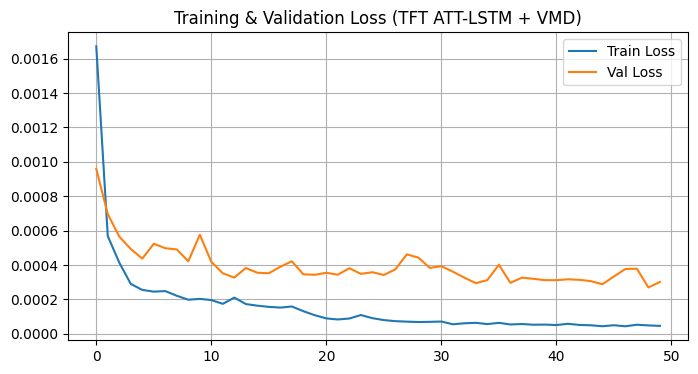

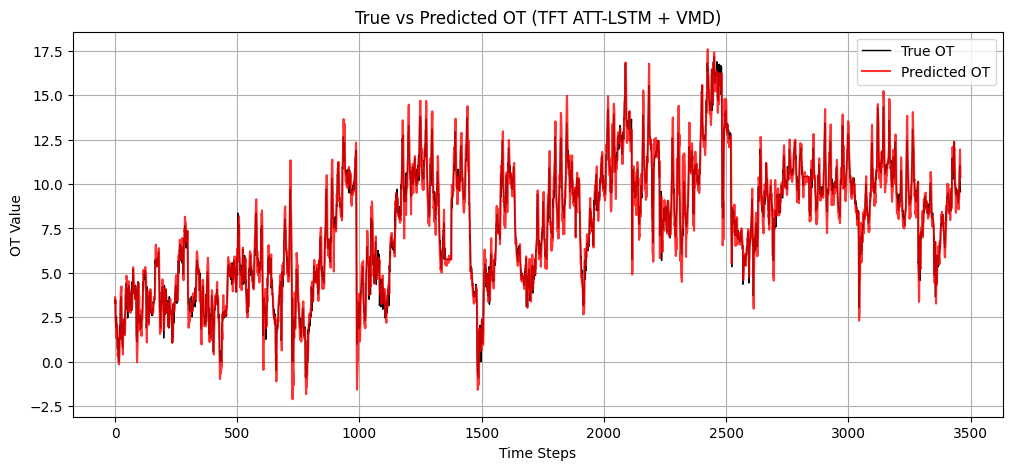

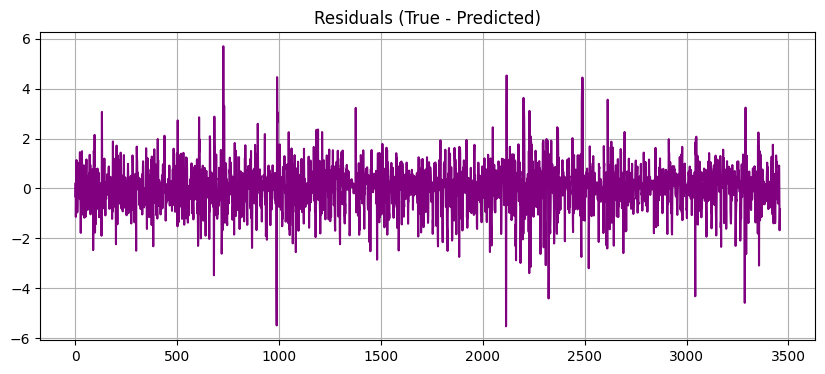

Total Area = 2185.328990396112
Area + = 1139.9140270613143
Area - = -1045.4149633347981


In [14]:
model_build_TFTattlstm_model = build_TFTattlstm_model6(
    input_shape=(SEQ_LEN, X_train_vmd.shape[2]),
    lstm1_units=64,
    dense_units=8,
    num_heads=32,
    model_dim=256,
    dropout=0.1
)

model_build_TFTattlstm_model.summary()

history_TFTattlstm_vmd = model_build_TFTattlstm_model.fit(
    X_train_vmd, y_train_vmd,
    validation_data=(X_test_vmd, y_test_vmd),
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    verbose=1
)

# Predict and inverse-transform
y_pred_TFTattlstm_vmd_scaled = model_build_TFTattlstm_model.predict(X_test_vmd)
# Flatten to 2D: (num_samples*time_steps, 1)
y_pred_flat = y_pred_TFTattlstm_vmd_scaled.reshape(-1, 1)
# Inverse transform
y_pred_TFTattlstm_vmd_true = scaler_y.inverse_transform(y_pred_flat)

# Optional: reshape back to (num_samples, time_steps)
y_pred_TFTattlstm_vmd_true = y_pred_TFTattlstm_vmd_true.reshape(y_pred_TFTattlstm_vmd_scaled.shape[0],
                                                                y_pred_TFTattlstm_vmd_scaled.shape[1])
# =====================================================
# 8️⃣ Visualization
# =====================================================
plt.figure(figsize=(8,4))
plt.plot(history_TFTattlstm_vmd.history['loss'], label='Train Loss')
plt.plot(history_TFTattlstm_vmd.history['val_loss'], label='Val Loss')
plt.title('Training & Validation Loss (TFT ATT-LSTM + VMD)')
plt.legend(); plt.grid(True); plt.show()

plt.figure(figsize=(12,5))
plt.plot(y_test_vmd_true, label='True OT', color='black', linewidth=1)
plt.plot(y_pred_TFTattlstm_vmd_true, label='Predicted OT', color='red', alpha=0.8)
plt.title('True vs Predicted OT (TFT ATT-LSTM + VMD)')
plt.xlabel('Time Steps'); plt.ylabel('OT Value')
plt.legend(); plt.grid(True); plt.show()

plt.figure(figsize=(10,4))
residuals = y_test_vmd_true.squeeze() - y_pred_TFTattlstm_vmd_true.squeeze()
plt.plot(residuals, color='purple')
plt.title('Residuals (True - Predicted)')
plt.grid(True); plt.show()


res = y_test_vmd_true.squeeze() - y_pred_TFTattlstm_vmd_true.squeeze()
area_total_TFTattlstm_vmd = np.trapezoid(np.abs(res))
print("Total Area =", area_total_TFTattlstm_vmd)
area_positive_TFTattlstm_vmd = np.trapezoid(np.clip(res, 0, None))
area_negative_TFTattlstm_vmd = np.trapezoid(np.clip(res, None, 0))
print("Area + =", area_positive_TFTattlstm_vmd)
print("Area - =", area_negative_TFTattlstm_vmd)

Model: "functional_19"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_21      │ (None, 24, 14)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_46 (LSTM)      │ (None, 24, 84)    │     33,264 │ input_layer_21[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_61          │ (None, 24, 84)    │          0 │ lstm_46[0][0]     │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_47 (LSTM)      │ (None, 24, 84)    │     33,264 │ input_layer_21[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_119 (Dense)   │ (None, 24, 8)     │        680 │ dropout_61[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_62          │ (None, 24, 84)    │          0 │ lstm_47[0][0]     │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ attention_layer__b… │ (None, 8)         │         80 │ dense_119[0][0]   │
│ (AttentionLayer_Ba… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_120 (Dense)   │ (None, 24, 8)     │        680 │ dropout_62[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ group1_bahdanau_ex… │ (None, 1, 8)      │          0 │ attention_layer_… │
│ (Lambda)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ performer_attentio… │ (None, 24, 32)    │      1,921 │ dense_120[0][0],  │
│ (PerformerAttentio… │                   │            │ dense_120[0][0],  │
│                     │                   │            │ dense_120[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ group1_last_step    │ (None, 8)         │          0 │ group1_bahdanau_… │
│ (Lambda)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ group2_last_step    │ (None, 32)        │          0 │ performer_attent… │
│ (Lambda)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_12      │ (None, 40)        │          0 │ group1_last_step… │
│ (Concatenate)       │                   │            │ group2_last_step… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_125 (Dense)   │ (None, 8)         │        328 │ concatenate_12[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_126 (Dense)   │ (None, 1)         │          9 │ dense_125[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 70,226 (274.32 KB)

 Trainable params: 70,225 (274.32 KB)

 Non-trainable params: 1 (4.00 B)

Epoch 1/100
870/870 ━━━━━━━━━━━━━━━━━━━━ 13s 14ms/step - loss: 0.0293 - mse: 0.0017 - val_loss: 0.0220 - val_mse: 7.2561e-04
Epoch 2/100
870/870 ━━━━━━━━━━━━━━━━━━━━ 13s 15ms/step - loss: 0.0159 - mse: 4.2087e-04 - val_loss: 0.0157 - val_mse: 4.4354e-04
Epoch 3/100
870/870 ━━━━━━━━━━━━━━━━━━━━ 12s 14ms/step - loss: 0.0133 - mse: 2.8935e-04 - val_loss: 0.0132 - val_mse: 3.2354e-04
Epoch 4/100
870/870 ━━━━━━━━━━━━━━━━━━━━ 12s 14ms/step - loss: 0.0115 - mse: 2.1556e-04 - val_loss: 0.0171 - val_mse: 4.6826e-04
Epoch 5/100
870/870 ━━━━━━━━━━━━━━━━━━━━ 13s 15ms/step - loss: 0.0111 - mse: 2.0329e-04 - val_loss: 0.0123 - val_mse: 2.7724e-04
Epoch 6/100
870/870 ━━━━━━━━━━━━━━━━━━━━ 12s 14ms/step - loss: 0.0099 - mse: 1.6257e-04 - val_loss: 0.0116 - val_mse: 2.5017e-04
Epoch 7/100
870/870 ━━━━━━━━━━━━━━━━━━━━ 12s 14ms/step - loss: 0.0102 - mse: 1.6991e-04 - val_loss: 0.0254 - val_mse: 8.2828e-04
Epoch 8/100
870/870 ━━━━━━━━━━━━━━━━━━━━ 12s 13ms/step - loss: 0.0094 - mse: 1.4476e-04 - val_loss: 0

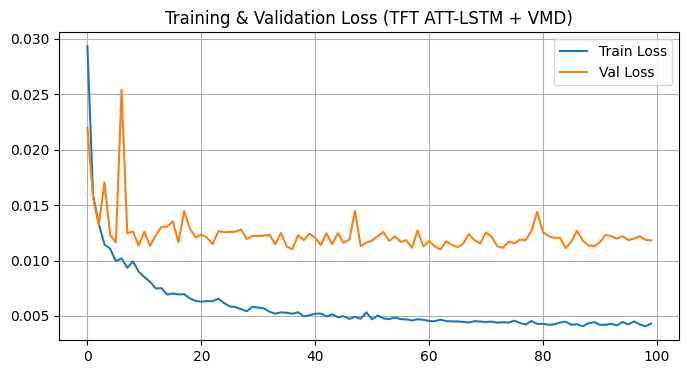

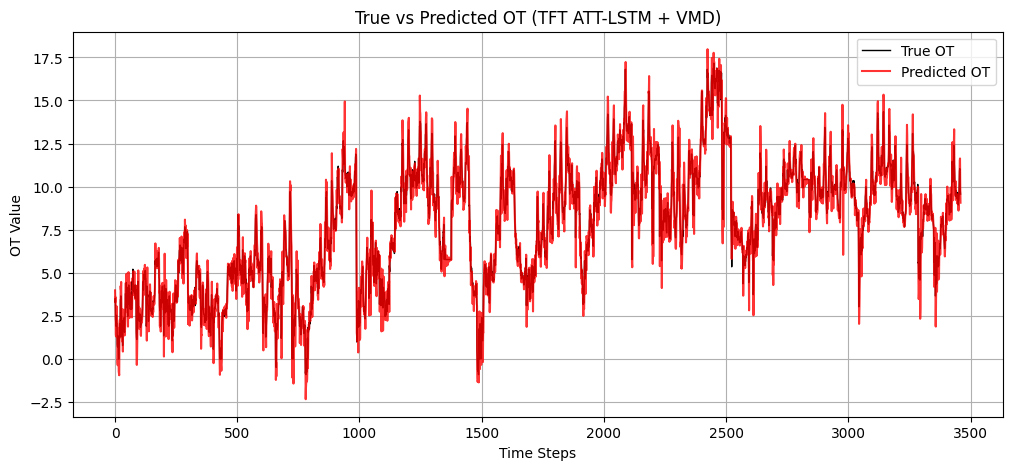

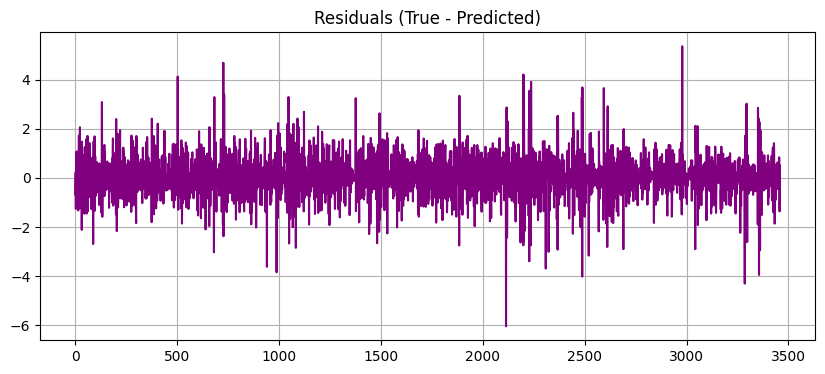

Total Area = 2046.2314954961184
Area + = 1116.0057992602242
Area - = -930.2256962358945


In [32]:
model_build_TFTattlstm_model = build_TFTattlstm_model7(
    input_shape=(SEQ_LEN, X_train_vmd.shape[2]),
    lstm1_units=84,
    dense_units=8,
    num_heads=32,
    model_dim=32,
    dropout=0.1
)

model_build_TFTattlstm_model.summary()

history_TFTattlstm_vmd = model_build_TFTattlstm_model.fit(
    X_train_vmd, y_train_vmd,
    validation_data=(X_test_vmd, y_test_vmd),
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    verbose=1
)

# Predict and inverse-transform
y_pred_TFTattlstm_vmd_scaled = model_build_TFTattlstm_model.predict(X_test_vmd)
# Flatten to 2D: (num_samples*time_steps, 1)
y_pred_flat = y_pred_TFTattlstm_vmd_scaled.reshape(-1, 1)
# Inverse transform
y_pred_TFTattlstm_vmd_true = scaler_y.inverse_transform(y_pred_flat)

# Optional: reshape back to (num_samples, time_steps)
y_pred_TFTattlstm_vmd_true = y_pred_TFTattlstm_vmd_true.reshape(y_pred_TFTattlstm_vmd_scaled.shape[0],
                                                                y_pred_TFTattlstm_vmd_scaled.shape[1])
# =====================================================
# 8️⃣ Visualization
# =====================================================
plt.figure(figsize=(8,4))
plt.plot(history_TFTattlstm_vmd.history['loss'], label='Train Loss')
plt.plot(history_TFTattlstm_vmd.history['val_loss'], label='Val Loss')
plt.title('Training & Validation Loss (TFT ATT-LSTM + VMD)')
plt.legend(); plt.grid(True); plt.show()

plt.figure(figsize=(12,5))
plt.plot(y_test_vmd_true, label='True OT', color='black', linewidth=1)
plt.plot(y_pred_TFTattlstm_vmd_true, label='Predicted OT', color='red', alpha=0.8)
plt.title('True vs Predicted OT (TFT ATT-LSTM + VMD)')
plt.xlabel('Time Steps'); plt.ylabel('OT Value')
plt.legend(); plt.grid(True); plt.show()

plt.figure(figsize=(10,4))
residuals = y_test_vmd_true.squeeze() - y_pred_TFTattlstm_vmd_true.squeeze()
plt.plot(residuals, color='purple')
plt.title('Residuals (True - Predicted)')
plt.grid(True); plt.show()


res = y_test_vmd_true.squeeze() - y_pred_TFTattlstm_vmd_true.squeeze()
area_total_TFTattlstm_vmd = np.trapezoid(np.abs(res))
print("Total Area =", area_total_TFTattlstm_vmd)
area_positive_TFTattlstm_vmd = np.trapezoid(np.clip(res, 0, None))
area_negative_TFTattlstm_vmd = np.trapezoid(np.clip(res, None, 0))
print("Area + =", area_positive_TFTattlstm_vmd)
print("Area - =", area_negative_TFTattlstm_vmd)

# AttnLSTM+SIMPLE

Model: "functional_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_9 (InputLayer)      │ (None, 24, 7)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_22 (LSTM)                  │ (None, 24, 122)        │        63,440 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_28 (Dropout)            │ (None, 24, 122)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ attention_layer__bahdanau_12    │ (None, 122)            │        15,128 │
│ (AttentionLayer_Bahdanau)       │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape_3 (Reshape)             │ (None, 1, 122)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_23 (LSTM)                  │ (None, 122)            │       119,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_29 (Dropout)            │ (None, 122)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_49 (Dense)                │ (None, 64)             │         7,872 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_50 (Dense)                │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 206,065 (804.94 KB)

 Trainable params: 206,065 (804.94 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
870/870 ━━━━━━━━━━━━━━━━━━━━ 12s 13ms/step - loss: 10.7303 - mae: 1.8814 - val_loss: 1.4730 - val_mae: 0.8808
Epoch 2/50
870/870 ━━━━━━━━━━━━━━━━━━━━ 11s 13ms/step - loss: 2.4684 - mae: 1.1628 - val_loss: 0.6028 - val_mae: 0.5700
Epoch 3/50
870/870 ━━━━━━━━━━━━━━━━━━━━ 10s 11ms/step - loss: 2.2041 - mae: 1.0946 - val_loss: 0.7482 - val_mae: 0.6475
Epoch 4/50
870/870 ━━━━━━━━━━━━━━━━━━━━ 10s 12ms/step - loss: 2.0056 - mae: 1.0445 - val_loss: 1.9728 - val_mae: 1.1801
Epoch 5/50
870/870 ━━━━━━━━━━━━━━━━━━━━ 11s 13ms/step - loss: 1.9684 - mae: 1.0332 - val_loss: 1.0717 - val_mae: 0.8177
Epoch 6/50
870/870 ━━━━━━━━━━━━━━━━━━━━ 11s 13ms/step - loss: 1.8698 - mae: 0.9996 - val_loss: 0.7007 - val_mae: 0.6787
Epoch 7/50
870/870 ━━━━━━━━━━━━━━━━━━━━ 11s 12ms/step - loss: 1.7987 - mae: 0.9859 - val_loss: 0.5539 - val_mae: 0.5396
Epoch 8/50
870/870 ━━━━━━━━━━━━━━━━━━━━ 10s 11ms/step - loss: 1.7514 - mae: 0.9680 - val_loss: 0.7753 - val_mae: 0.7211
Epoch 9/50
870/870 ━━━━━━━━━━━━━━━━━━━━

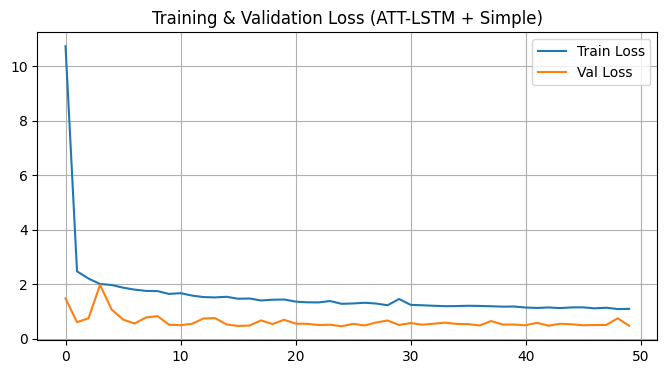

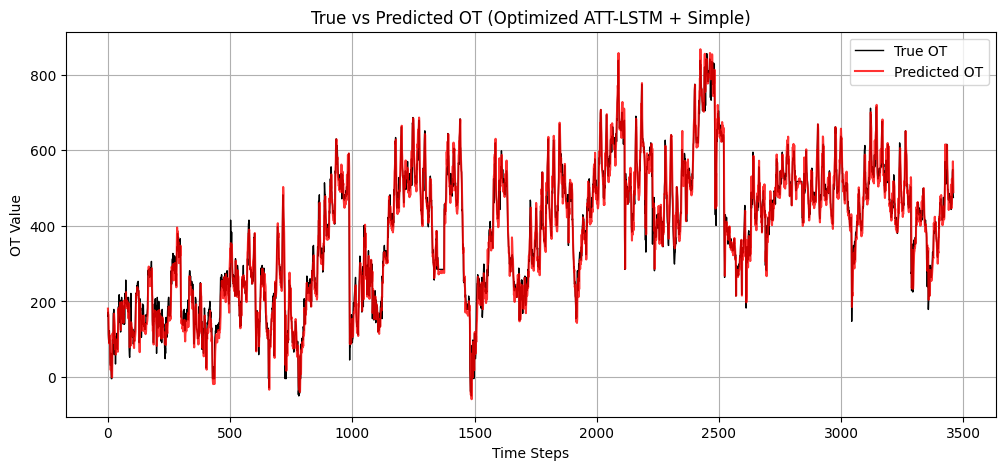

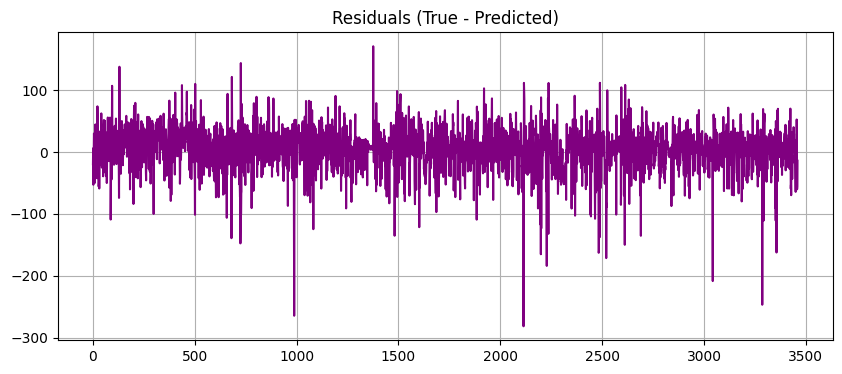

Total Area = 86441.11581173335
Area + = 48457.73624675428
Area - = -37983.379564979085


In [16]:
model_build_attlstm_model = build_attlstm_model(
    input_shape=(SEQ_LEN, X_train_simple.shape[-1]),
    lstm1_units=122,
    lstm2_units=122,
    dense_units=64
)

model_build_attlstm_model.summary()

history_attlstm_simple = model_build_attlstm_model.fit(
    X_train_simple, y_train_simple,
    validation_data=(X_test_simple, y_test_simple),
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    verbose=1
)

# Predict (inverse-transform from original OT scaling)
y_pred_attlstm_simple_ga_scaled = model_build_attlstm_model.predict(X_test_simple)
y_pred_attlstm_simple_true = scaler_y.inverse_transform(y_pred_attlstm_simple_ga_scaled)

# =====================================================
# 8️⃣ Visualization
# =====================================================
plt.figure(figsize=(8,4))
plt.plot(history_attlstm_simple.history['loss'], label='Train Loss')
plt.plot(history_attlstm_simple.history['val_loss'], label='Val Loss')
plt.title('Training & Validation Loss (ATT-LSTM + Simple)')
plt.legend(); plt.grid(True); plt.show()

plt.figure(figsize=(12,5))
plt.plot(y_test_simple_true, label='True OT', color='black', linewidth=1)
plt.plot(y_pred_attlstm_simple_true, label='Predicted OT', color='red', alpha=0.8)
plt.title('True vs Predicted OT (Optimized ATT-LSTM + Simple)')
plt.xlabel('Time Steps'); plt.ylabel('OT Value')
plt.legend(); plt.grid(True); plt.show()

plt.figure(figsize=(10,4))
residuals = y_test_simple_true.squeeze() - y_pred_attlstm_simple_true.squeeze()
plt.plot(residuals, color='purple')
plt.title('Residuals (True - Predicted)')
plt.grid(True); plt.show()

res = y_test_simple_true.squeeze() - y_pred_attlstm_simple_true.squeeze()
area_total_attlstm_simple = np.trapezoid(np.abs(res))
print("Total Area =", area_total_attlstm_simple)
area_positive_attlstm_simple = np.trapezoid(np.clip(res, 0, None))
area_negative_attlstm_simple = np.trapezoid(np.clip(res, None, 0))
print("Area + =", area_positive_attlstm_simple)
print("Area - =", area_negative_attlstm_simple)

# BidirectionalLSTM_SIMPLE

In [17]:
def build_Bidirectional_lstm_model(input_shape, units=LSTM_UNITS, dropout=DROPOUT):
    inp = Input(shape=input_shape)
    x = Bidirectional(LSTM(units, return_sequences=True))(inp)
    x = Dropout(dropout)(x)
    x = LSTM(units, return_sequences=False)(x)
    x = Dropout(dropout)(x)
    out = Dense(1)(x)
    model = Model(inp, out)
    model.compile(optimizer=Adam(LEARNING_RATE), loss='mse', metrics=['mae'])
    return model

Bidirectional_lstm = build_Bidirectional_lstm_model((SEQ_LEN, K),100)
Bidirectional_lstm.summary()

# Early stopping
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Train model
history_Bidirectional_lstm_simple = Bidirectional_lstm.fit(
    X_train_simple, y_train_simple,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    validation_data=(X_test_simple, y_test_simple),
    callbacks=[early_stop],
    verbose=1
)

# Plot training history
plt.figure(figsize=(8, 4))
plt.plot(history_Bidirectional_lstm_simple.history['loss'], label='Training Loss')
plt.plot(history_Bidirectional_lstm_simple.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('MSE Loss')
plt.title('Bidirectional LSTM Training Performance')
plt.legend()
plt.grid(True)
plt.show()

# Make predictions
y_pred_scaled_Bidirectional_lstm = Bidirectional_lstm.predict(X_test_simple)
y_pred_Bidirectional_lstm_simple_true = scaler_y.inverse_transform(y_pred_scaled_Bidirectional_lstm.reshape(-1, 1)).flatten()

# Plot predictions vs true values
plt.figure(figsize=(12, 5))
plt.plot(y_test_simple_true, label='True OT', color='blue')
plt.plot(y_pred_Bidirectional_lstm_simple_true, label='Predicted OT', color='green')
plt.xlabel('Time Steps')
plt.ylabel('Oil Temperature')
plt.title('Advanced LSTM Predictions vs True Values')
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(10,4))
res = y_test_simple_true.squeeze() - y_pred_Bidirectional_lstm_simple_true.squeeze() 
plt.plot(res, color='purple')
plt.title('Residuals (True - Pred)')
plt.grid(True)
plt.show()

res = y_test_simple_true.squeeze() - y_pred_Bidirectional_lstm_simple_true
area_total_Bidirectional_lstm_simple = np.trapezoid(np.abs(res))
print("Total Area =", area_total_Bidirectional_lstm_simple)
area_positive_Bidirectional_lstm_simple = np.trapezoid(np.clip(res, 0, None))
area_negative_Bidirectional_lstm_simple = np.trapezoid(np.clip(res, None, 0))
print("Area + =", area_positive_Bidirectional_lstm_simple)
print("Area - =", area_negative_Bidirectional_lstm_simple)

Model: "functional_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_10 (InputLayer)     │ (None, 24, 8)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_4 (Bidirectional) │ (None, 24, 200)        │        87,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_30 (Dropout)            │ (None, 24, 200)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_25 (LSTM)                  │ (None, 100)            │       120,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_31 (Dropout)            │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_51 (Dense)                │ (None, 1)              │           101 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 207,701 (811.33 KB)

 Trainable params: 207,701 (811.33 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50


ValueError: Input 0 of layer "functional_10" is incompatible with the layer: expected shape=(None, 24, 8), found shape=(None, 24, 7)

# LSTM_VMD

In [ ]:
def build_lstm_model(input_shape, units=LSTM_UNITS, dropout=DROPOUT):
    inp = Input(shape=input_shape)
    x = LSTM(units, return_sequences=True)(inp)
    x = Dropout(dropout)(x)
    x = LSTM(units, return_sequences=False)(x)
    x = Dropout(dropout)(x)
    out = Dense(1)(x)
    model = Model(inp, out)
    model.compile(optimizer=Adam(LEARNING_RATE), loss='mse', metrics=['mae'])
    return model

model_lstm_model= build_lstm_model((SEQ_LEN, K),128)
model_lstm_model.summary()

# ---------------------------
# 6. Train
# ---------------------------
history_lstm_vmd = model_lstm_model.fit(
    X_train_vmd, y_train_vmd,
    validation_data=(X_test_vmd, y_test_vmd),
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    verbose=1
)

# ---------------------------
# 7. Predict & inverse-transform
# ---------------------------
y_pred_lstm_vmd_scaled = model_lstm_model.predict(X_test_vmd)
y_pred_lstm_vmd_true = scaler_y.inverse_transform(y_pred_lstm_vmd_scaled).flatten()

# ---------------------------
# 9. Plots
# ---------------------------
plt.figure(figsize=(8,4))
plt.plot(history_lstm_vmd.history['loss'], label='train loss')
plt.plot(history_lstm_vmd.history['val_loss'], label='val loss')
plt.xlabel('epoch'); plt.ylabel('mse'); plt.legend(); plt.grid(True)
plt.title('Train / Val Loss')
plt.show()

plt.figure(figsize=(12,5))
plt.plot(y_test_vmd_true, label='True OT', color='black', linewidth=1)
plt.plot(y_pred_lstm_vmd_true, label='Predicted OT', color='red', alpha=0.8)
plt.xlabel('time steps (test)')
plt.ylabel('OT')
plt.title('True vs Predicted OT (VMD -> LSTM)')
plt.legend(); plt.grid(True)
plt.show()

plt.figure(figsize=(10,4))
res = y_test_vmd_true - y_pred_lstm_vmd_true.squeeze()  
plt.plot(res, color='purple')
plt.title('Residuals (True - Pred)')
plt.grid(True)
plt.show()

res = y_test_vmd_true.squeeze() - y_pred_lstm_vmd_true
area_total_lstm_vmd = np.trapezoid(np.abs(res))
print("Total Area =", area_total_lstm_vmd)
area_positive_lstm_vmd = np.trapezoid(np.clip(res, 0, None))
area_negative_lstm_vmd = np.trapezoid(np.clip(res, None, 0))
print("Area + =", area_positive_lstm_vmd)
print("Area - =", area_negative_lstm_vmd)

# Compare Models

In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np

def compute_metrics(y_true, y_pred):
    min_len = min(len(y_true), len(y_pred))
    y_true, y_pred = y_true[:min_len], y_pred[:min_len]
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    return mse, rmse, mae, r2

# Compute metrics
mse_Attlstm_vmd, rmse_Attlstm_vmd, mae_Attlstm_vmd, r2_attlstm_vmd = compute_metrics(y_pred_attlstm_vmd_true, y_test_vmd_true)
mse_TAttlstm_vmd, rmse_TAttlstm_vmd, mae_TAttlstm_vmd, r2_Tattlstm_vmd = compute_metrics(y_pred_Tattlstm_vmd_true, y_test_vmd_true)
mse_TFTAttlstm_vmd, rmse_TFTAttlstm_vmd, mae_TFTAttlstm_vmd, r2_TFTattlstm_vmd = compute_metrics(y_pred_TFTattlstm_vmd_true, y_test_vmd_true)
mse_Lstm_Bidirectional_simple, rmse_Lstm_Bidirectional_simple, mae_Lstm_Bidirectional_simple, r2_Lstm_Bidirectional_simple = compute_metrics(y_pred_Bidirectional_lstm_simple_true, y_test_simple_true)
mse_Attlstm_simple, rmse_Attlstm_simple, mae_Attlstm_simple, r2_attlstm_simple = compute_metrics(y_pred_attlstm_simple_true, y_test_simple_true)
mse_Lstm_vmd, rmse_Lstm_vmd, mae_Lstm_vmd, r2_Lstm_vmd = compute_metrics(y_pred_lstm_vmd_true, y_test_vmd_true)

# Print comparison
print("📈 Model Performance Comparison")
print(f"ATT-LSTM-VMD: MSE={mse_Attlstm_vmd:.4f}, RMSE={rmse_Attlstm_vmd:.4f}, MAE={mae_Attlstm_vmd:.4f}, R²={r2_attlstm_vmd:.4f}, total_area={area_total_attlstm_vmd:.4f}")
print(f"TATT-LSTM-VMD: MSE={mse_TAttlstm_vmd:.4f}, RMSE={rmse_TAttlstm_vmd:.4f}, MAE={mae_TAttlstm_vmd:.4f}, R²={r2_Tattlstm_vmd:.4f}, total_area={area_total_Tattlstm_vmd:.4f}")
print(f"TFTATT-LSTM-VMD: MSE={mse_TFTAttlstm_vmd:.4f}, RMSE={rmse_TFTAttlstm_vmd:.4f}, MAE={mae_TFTAttlstm_vmd:.4f}, R²={r2_TFTattlstm_vmd:.4f}, total_area={area_total_TFTattlstm_vmd:.4f}")
print(f"Bidirectional_Lstm_Simple: MSE={mse_Lstm_Bidirectional_simple:.4f}, RMSE={rmse_Lstm_Bidirectional_simple:.4f}, MAE={mae_Lstm_Bidirectional_simple:.4f}, R²={r2_Lstm_Bidirectional_simple:.4f}, total_area={area_total_Bidirectional_lstm_simple:.4f}")
print(f"Attlstm_Simple: MSE={mse_Attlstm_simple:.4f}, RMSE={rmse_Attlstm_simple:.4f}, MAE={mae_Attlstm_simple:.4f}, R²={r2_attlstm_simple:.4f}, total_area={area_total_attlstm_simple:.4f}")
print(f"Lstm_vmd: MSE={mse_Lstm_vmd:.4f}, RMSE={rmse_Lstm_vmd:.4f}, MAE={mae_Lstm_vmd:.4f}, R²={r2_Lstm_vmd:.4f}, total_area={area_total_lstm_vmd:.4f}")


In [ ]:
diff = y_train_simple - y_train_vmd
plt.figure(figsize=(10,4))
plt.plot(diff, color='orange')
plt.title('Difference: y_train_simple vs y_train_vmd')
plt.xlabel('Time steps')
plt.ylabel('Temperature difference')
plt.grid(True)
plt.show()

y_test_vmd_true = scaler_y.inverse_transform(y_test_vmd)
y_test_simple_true = scaler_y.inverse_transform(y_test_simple)
diff = y_test_simple_true - y_test_vmd_true
plt.figure(figsize=(10,4))
plt.plot(diff, color='orange')
plt.title('Difference: VMD-test-true vs Simple-test-true of OT')
plt.xlabel('Time steps')
plt.ylabel('Temperature difference')
plt.grid(True)
plt.show()